# 1 network construction & transform into panel data

In [1]:
# basic usage
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     


# tigramite
import sklearn
from tigramite.toymodels import surrogate_generator 
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI



In [2]:
df = pd.read_excel('Shenwan industry closing price.xlsx')

# 将时间列转换为 datetime 对象
df['时间'] = pd.to_datetime(df['时间'])

# 使用上一个交易日数据填充缺失值
df = df.fillna(method='ffill')

# 列重命名
# 创建中文列名到英文列名的映射
column_mapping = {
    '时间': 'Date',
    '农林牧渔(申万)': 'Agriculture',
    '基础化工(申万)': 'Basic_Chemicals',
    '钢铁(申万)': 'Steel',
    '有色金属(申万)': 'Nonferrous_Metals',
    '电子(申万)': 'Electronics',
    '家用电器(申万)': 'Home_Appliances',
    '食品饮料(申万)': 'Food_Beverage',
    '纺织服饰(申万)': 'Textile_Clothing',
    '轻工制造(申万)': 'Light_Manufacturing',
    '医药生物(申万)': 'Pharmaceuticals',
    '公用事业(申万)': 'Utilities',
    '交通运输(申万)': 'Transportation',
    '房地产(申万)': 'Real_Estate',
    '商贸零售(申万)': 'Retail',
    '社会服务(申万)': 'Social_Services',
    '综合(申万)': 'Comprehensive',
    '建筑装饰(申万)': 'Construction_Decoration',
    '电力设备(申万)': 'Electrical_Equipment',
    '国防军工(申万)': 'Defense',
    '计算机(申万)': 'Computer',
    '传媒(申万)': 'Media',
    '通信(申万)': 'Telecommunications',
    '银行(申万)': 'Banking',
    '非银金融(申万)': 'Non_Bank_Financials',
    '汽车(申万)': 'Automobile',
    '机械设备(申万)': 'Machinery',
    '煤炭(申万)': 'Coal',
    '石油石化(申万)': 'Petroleum_Chemicals',
    '环保(申万)': 'Environmental_Protection',
    '美容护理(申万)': 'Beauty_Care'
}

# 重命名列名
df.rename(columns=column_mapping, inplace=True)

df.head()
df

Date  Agriculture  Basic_Chemicals    Steel  Nonferrous_Metals  \
0    2000-01-04      1027.66          1025.03  1022.21            1029.82   
1    2000-01-05      1028.87          1034.06  1022.25            1032.60   
2    2000-01-06      1065.67          1081.01  1056.28            1071.66   
3    2000-01-07      1106.19          1114.65  1102.06            1116.23   
4    2000-01-10      1130.06          1128.31  1107.30            1178.55   
...         ...          ...              ...      ...                ...   
6047 2024-12-17      2648.05          3408.38  2198.28            4498.61   
6048 2024-12-18      2631.79          3412.17  2224.98            4490.01   
6049 2024-12-19      2617.96          3401.35  2212.49            4471.53   
6050 2024-12-20      2610.43          3404.05  2182.73            4455.03   
6051 2024-12-23      2610.43          3404.05  2182.73            4455.03   

      Electronics  Home_Appliances  Food_Beverage  Textile_Clothing  \
0         1043.81          1033.04        1024.64           1024.90   
1         1047.01          1022.01        1029.26           1029.68   
2         1095.48          1080.93        1068.67           1058.86   
3         1128.03          1147.08        1110.33           1101.92   
4         1144.21          1163.55        1128.06           1133.90   
...           ...              ...            ...               ...   
6047      4362.33          8403.82       18460.89           1559.58   
6048      4461.18          8464.56       18477.63           1551.40   
6049      4542.54          8498.45       18236.22           1543.61   
6050      4651.29          8478.42       18159.34           1564.56   
6051      4651.29          8478.42       18159.34           1564.56   

      Light_Manufacturing  ...   Media  Telecommunications  Banking  \
0                 1025.14  ...  246.95             1078.71  1043.67   
1                 1032.21  ...  249.56             1060.54  1030.93   
2                 1069.82  ...  261.12             1114.07  1068.45   
3                 1107.35  ...  268.18             1143.50  1109.98   
4                 1126.33  ...  274.29             1160.24  1138.34   
...                   ...  ...     ...                 ...      ...   
6047              2143.89  ...  710.39             2949.55  3757.18   
6048              2144.13  ...  717.75             2987.52  3800.14   
6049              2126.60  ...  718.38             3086.29  3765.47   
6050              2128.98  ...  718.48             3091.02  3760.35   
6051              2128.98  ...  718.48             3091.02  3760.35   

      Non_Bank_Financials  Automobile  Machinery     Coal  \
0                  445.32      981.88     276.66  1026.58   
1                  441.82      984.07     278.46  1024.39   
2                  457.14     1019.39     289.16  1067.10   
3                  473.01     1051.07     299.87  1098.21   
4                  501.68     1069.38     306.25  1118.49   
...                   ...         ...        ...      ...   
6047              1908.72     6484.51    1553.35  2997.18   
6048              1907.82     6525.94    1557.80  3023.95   
6049              1904.45     6514.71    1567.54  2964.70   
6050              1905.94     6511.85    1580.34  2897.37   
6051              1905.94     6511.85    1580.34  2897.37   

      Petroleum_Chemicals  Environmental_Protection  Beauty_Care  
0                 1023.34                   1022.60      1025.26  
1                 1035.75                   1026.90      1016.83  
2                 1091.20                   1069.32      1045.77  
3                 1111.47                   1099.73      1072.10  
4                 1103.32                   1128.96      1109.70  
...                   ...                       ...          ...  
6047              2307.71                   1734.81      4696.74  
6048              2316.41                   1744.31      4684.57  
6049              2293.61                   

In [3]:
# Calculate the log returns for each column (except the Date column)
log_returns = df.set_index('Date').apply(lambda x: x / x.shift(1)).apply(lambda x: x.transform('log')).dropna()



log_returns.to_excel('log_returns.xlsx')

log_returns

Agriculture  Basic_Chemicals     Steel  Nonferrous_Metals  \
Date                                                                    
2000-01-05     0.001177         0.008771  0.000039           0.002696   
2000-01-06     0.035143         0.044403  0.032747           0.037129   
2000-01-07     0.037318         0.030645  0.042428           0.040748   
2000-01-10     0.021349         0.012180  0.004743           0.054328   
2000-01-11    -0.023168        -0.049275 -0.045989          -0.054892   
...                 ...              ...       ...                ...   
2024-12-17    -0.017088        -0.014849 -0.012284          -0.007997   
2024-12-18    -0.006159         0.001111  0.012073          -0.001914   
2024-12-19    -0.005269        -0.003176 -0.005629          -0.004124   
2024-12-20    -0.002880         0.000793 -0.013542          -0.003697   
2024-12-23     0.000000         0.000000  0.000000           0.000000   

            Electronics  Home_Appliances  Food_Beverage  Textile_Clothing  \
Date                                                                        
2000-01-05     0.003061        -0.010735       0.004499          0.004653   
2000-01-06     0.045254         0.056051       0.037575          0.027945   
2000-01-07     0.029280         0.059398       0.038242          0.039861   
2000-01-10     0.014242         0.014256       0.015842          0.028609   
2000-01-11    -0.036817        -0.060164      -0.024853         -0.050101   
...                 ...              ...            ...               ...   
2024-12-17    -0.011286        -0.006438       0.002731         -0.042862   
2024-12-18     0.022407         0.007202       0.000906         -0.005259   
2024-12-19     0.018073         0.003996      -0.013151         -0.005034   
2024-12-20     0.023658        -0.002360      -0.004225          0.013481   
2024-12-23     0.000000         0.000000       0.000000          0.000000   

            Light_Manufacturing  Pharmaceuticals  ...     Media  \
Date                                              ...             
2000-01-05             0.006873         0.002782  ...  0.010513   
2000-01-06             0.035788         0.036609  ...  0.045281   
2000-01-07             0.034479         0.037059  ...  0.026678   
2000-01-10             0.016995         0.019355  ...  0.022528   
2000-01-11            -0.028457        -0.038964  ... -0.014579   
...                         ...              ...  ...       ...   
2024-12-17            -0.032432        -0.016272  ... -0.040714   
2024-12-18             0.000112         0.001656  ...  0.010307   
2024-12-19            -0.008209        -0.002476  ...  0.000877   
2024-12-20             0.001119         0.003937  ...  0.000139   
2024-12-23             0.000000         0.000000  ...  0.000000   

            Telecommunications   Banking  Non_Bank_Financials  Automobile  \
Date                                                                        
2000-01-05           -0.016988 -0.012282            -0.007891    0.002228   
2000-01-06            0.049242  0.035748             0.034087    0.035263   
2000-01-07            0.026074  0.038133             0.034127    0.030604   
2000-01-10            0.014533  0.025229             0.058846    0.017270   
2000-01-11           -0.063119 -0.052767            -0.064464   -0.035648   
...                        ...       ...                  ...         ...   
2024-12-17           -0.006408 -0.002164            -0.001733   -0.003313   
2024-12-18            0.012791  0.011369            -0.000472    0.006369   
2024-12-19            0.032526 -0.009165            -0.001768   -0.001722   
2024-12-20            0.001531 -0.001361             0.000782   -0.000439   
2024-12-23            0.000000  0.000000             0.000000    0.000000   

            Machinery      Coal  Petroleum_Chemicals  \
Date                                                   
2000-01-05   0.006485 -0.002136             0.012054   
2000-01-06   0.037

In [4]:
import pandas as pd

# 加载数据
log_returns_df = pd.read_excel('log_returns.xlsx')  # 替换为你的文件路径

# 确保 'Date' 列被正确保留
log_returns_df['Date'] = pd.to_datetime(log_returns_df['Date'])  # 转换为日期格式

# 筛选指定行业并保留 'Date' 列
selected_industries = [
    'Food_Beverage', 'Steel', 'Beauty_Care', 'Nonferrous_Metals',
    'Basic_Chemicals', 'Pharmaceuticals', 'Retail', 'Coal',
    'Social_Services', 'Petroleum_Chemicals'
]
log_returns_df = log_returns_df[['Date'] + selected_industries]  # 保留 'Date' 和所需的行业列

# 创建日期和行业列表
dates = log_returns_df['Date'].unique()
industries = log_returns_df.columns[1:]  # 排除 'Date' 列

# 初始化空的 DataFrame 用于存储结果
panel_data_chunks = []

# 按日期生成 (i, j) 对
for date in dates:
    # 创建当前日期下的行业配对
    date_pairs = pd.DataFrame([(f"({i}, {j})", date) for i in industries for j in industries], 
                              columns=['pairid', 'date'])
    panel_data_chunks.append(date_pairs)

# 合并所有日期的配对数据
panel_data = pd.concat(panel_data_chunks, ignore_index=True)

# 保存结果
panel_data.to_csv('panel_data.csv', index=False)  # 保存为 CSV 文件

panel_data


pairid       date
0                   (Food_Beverage, Food_Beverage) 2000-01-05
1                           (Food_Beverage, Steel) 2000-01-05
2                     (Food_Beverage, Beauty_Care) 2000-01-05
3               (Food_Beverage, Nonferrous_Metals) 2000-01-05
4                 (Food_Beverage, Basic_Chemicals) 2000-01-05
...                                            ...        ...
605095      (Petroleum_Chemicals, Pharmaceuticals) 2024-12-23
605096               (Petroleum_Chemicals, Retail) 2024-12-23
605097                 (Petroleum_Chemicals, Coal) 2024-12-23
605098      (Petroleum_Chemicals, Social_Services) 2024-12-23
605099  (Petroleum_Chemicals, Petroleum_Chemicals) 2024-12-23

[605100 rows x 2 columns]

In [5]:
import pandas as pd

# 定义时间节点和阶段
time_periods = [
    ('1999-09', '2000-12', 'Overheat'),
    ('2000-12', '2001-03', 'Recovery'),
    ('2001-03', '2002-04', 'Reflation'),
    ('2002-04', '2003-06', 'Stagflation'),
    ('2003-06', '2004-07', 'Overheat'),
    ('2004-07', '2006-03', 'Reflation'),
    ('2006-03', '2008-03', 'Overheat'),
    ('2008-03', '2009-06', 'Reflation'),
    ('2009-06', '2011-09', 'Overheat'),
    ('2011-09', '2016-03', 'Reflation'),
    ('2016-03', '2017-02', 'Recovery'),
    ('2017-02', '2018-09', 'Overheat'),
    ('2018-09', '2020-03', 'Stagflation'),
    ('2020-03', '2020-11', 'Recovery'),
    ('2020-11', '2021-06', 'Overheat'),
    ('2021-06', '2022-09', 'Stagflation'),
    ('2022-09', '2024-01', 'Reflation'),
    ('2024-01', '2025-01', 'Stagflation')
]

# 确保 'date' 列是日期类型
panel_data['date'] = pd.to_datetime(panel_data['date'])

# 准备时间范围为日期格式
time_periods = [(pd.to_datetime(start), pd.to_datetime(end), phase) for start, end, phase in time_periods]

# 根据时间范围添加 phase 列
def assign_phase(date):
    for start, end, phase in time_periods:
        if start <= date < end:
            return phase
    return 'Unknown'

panel_data['phase'] = panel_data['date'].apply(assign_phase)

panel_data.to_csv('panel_data.csv', index=False)  # 保存为 CSV 文件

# 保存结果
panel_data

pairid       date        phase
0                   (Food_Beverage, Food_Beverage) 2000-01-05     Overheat
1                           (Food_Beverage, Steel) 2000-01-05     Overheat
2                     (Food_Beverage, Beauty_Care) 2000-01-05     Overheat
3               (Food_Beverage, Nonferrous_Metals) 2000-01-05     Overheat
4                 (Food_Beverage, Basic_Chemicals) 2000-01-05     Overheat
...                                            ...        ...          ...
605095      (Petroleum_Chemicals, Pharmaceuticals) 2024-12-23  Stagflation
605096               (Petroleum_Chemicals, Retail) 2024-12-23  Stagflation
605097                 (Petroleum_Chemicals, Coal) 2024-12-23  Stagflation
605098      (Petroleum_Chemicals, Social_Services) 2024-12-23  Stagflation
605099  (Petroleum_Chemicals, Petroleum_Chemicals) 2024-12-23  Stagflation

[605100 rows x 3 columns]

## 1.1 Create Causal Network by PCMCI+

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pickle

# 定义显著行业列表
selected_industries = [
    'Food_Beverage', 'Steel', 'Beauty_Care', 'Nonferrous_Metals',
    'Basic_Chemicals', 'Pharmaceuticals', 'Retail', 'Coal',
    'Social_Services', 'Petroleum_Chemicals'
]

# 加载对数收益率数据
log_returns = pd.read_excel('log_returns.xlsx')  # 替换为你的数据路径
log_returns['Date'] = pd.to_datetime(log_returns['Date'])
log_returns = log_returns.set_index('Date')

# 筛选指定行业
df = log_returns[selected_industries].reset_index()

# 定义时间节点和阶段
time_periods = [
    ('1999-09', '2000-12', 'Overheat'),
    ('2000-12', '2001-03', 'Recovery'),
    ('2001-03', '2002-04', 'Reflation'),
    ('2002-04', '2003-06', 'Stagflation'),
    ('2003-06', '2004-07', 'Overheat'),
    ('2004-07', '2006-03', 'Reflation'),
    ('2006-03', '2008-03', 'Overheat'),
    ('2008-03', '2009-06', 'Reflation'),
    ('2009-06', '2011-09', 'Overheat'),
    ('2011-09', '2016-03', 'Reflation'),
    ('2016-03', '2017-02', 'Recovery'),
    ('2017-02', '2018-09', 'Overheat'),
    ('2018-09', '2020-03', 'Stagflation'),
    ('2020-03', '2020-11', 'Recovery'),
    ('2020-11', '2021-06', 'Overheat'),
    ('2021-06', '2022-09', 'Stagflation'),
    ('2022-09', '2024-01', 'Reflation'),
    ('2024-01', '2024-11', 'Stagflation')
]
time_periods = [(pd.to_datetime(start), pd.to_datetime(end), label) for start, end, label in time_periods]

# 初始化存储网络的字典
stored_networks = {}

# 按时间节点切分数据
sliced_data = []
for start, end, label in time_periods:
    segment = df[(df['Date'] >= start) & (df['Date'] < end)].copy()
    segment['Time_Period'] = f"{start.strftime('%Y-%m')} ~ {end.strftime('%Y-%m')}"
    sliced_data.append((segment, label))

# 循环处理每个时间段的切片数据
for segment, phase_label in sliced_data:
    # 筛选显著行业数据
    data = segment.set_index('Date')[selected_industries]

    # 转换为 Tigramite 的 DataFrame 格式
    dataframe = pp.DataFrame(
        data.values,
        datatime={0: np.arange(len(data))},
        var_names=data.columns
    )

    # 初始化 PCMCI+ 分析
    parcorr = ParCorr(significance='analytic')
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)

    # 运行 PCMCI+
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=0, pc_alpha=None)

    # 获取时间段具体范围
    time_period_label = segment['Time_Period'].iloc[0]

    # 转换为 NetworkX 图
    graph_nx = nx.DiGraph()

    # 确保所有节点被添加到图中
    for industry in selected_industries:
        graph_nx.add_node(industry)

    # 根据 PCMCI+ 结果添加边
    var_names = data.columns
    for j, row in enumerate(results['graph']):
        for k, value in enumerate(row):
            if '-->' in value:  # j influences k
                graph_nx.add_edge(var_names[j], var_names[k])
            elif '<--' in value:  # k influences j
                graph_nx.add_edge(var_names[k], var_names[j])

    # 存储 NetworkX 图
    stored_networks[time_period_label] = graph_nx

# 保存所有网络到文件
with open('stored_networks.pkl', 'wb') as f:
    pickle.dump(stored_networks, f)

print(f"Stored {len(stored_networks)} NetworkX graphs for future analysis.")


Stored 18 NetworkX graphs for future analysis.


Adjust the figure

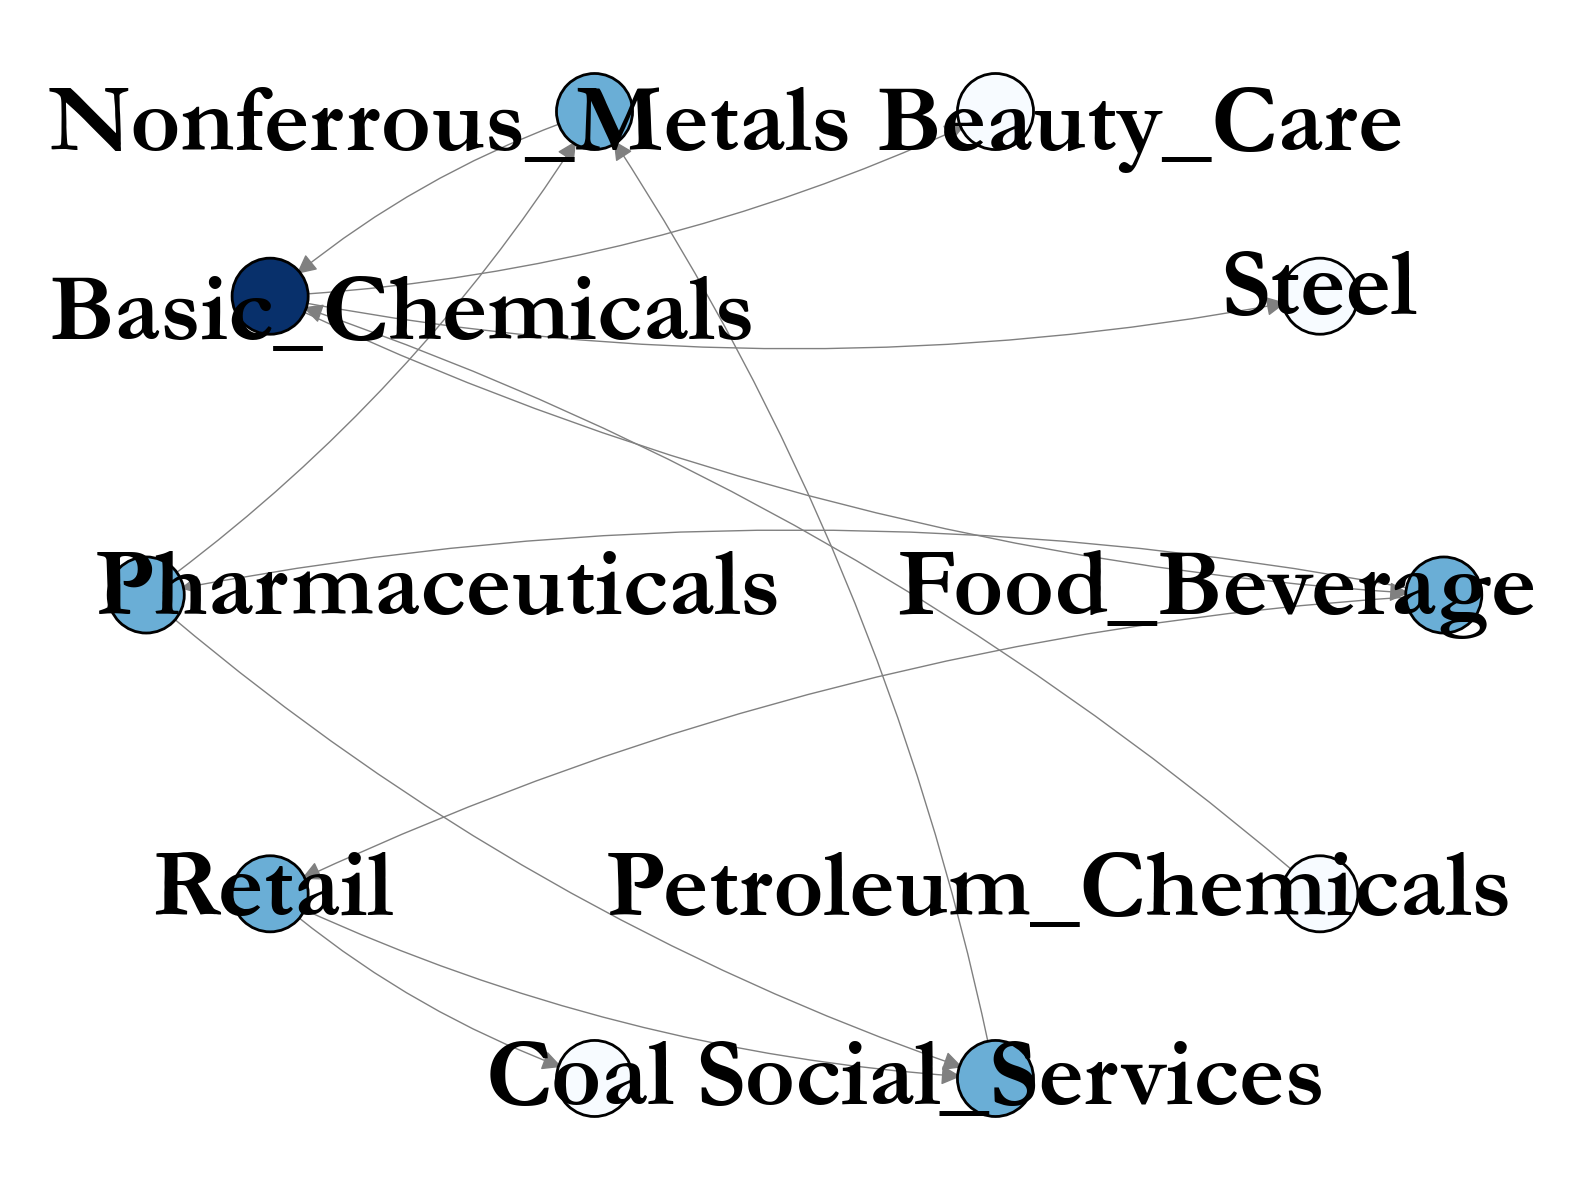

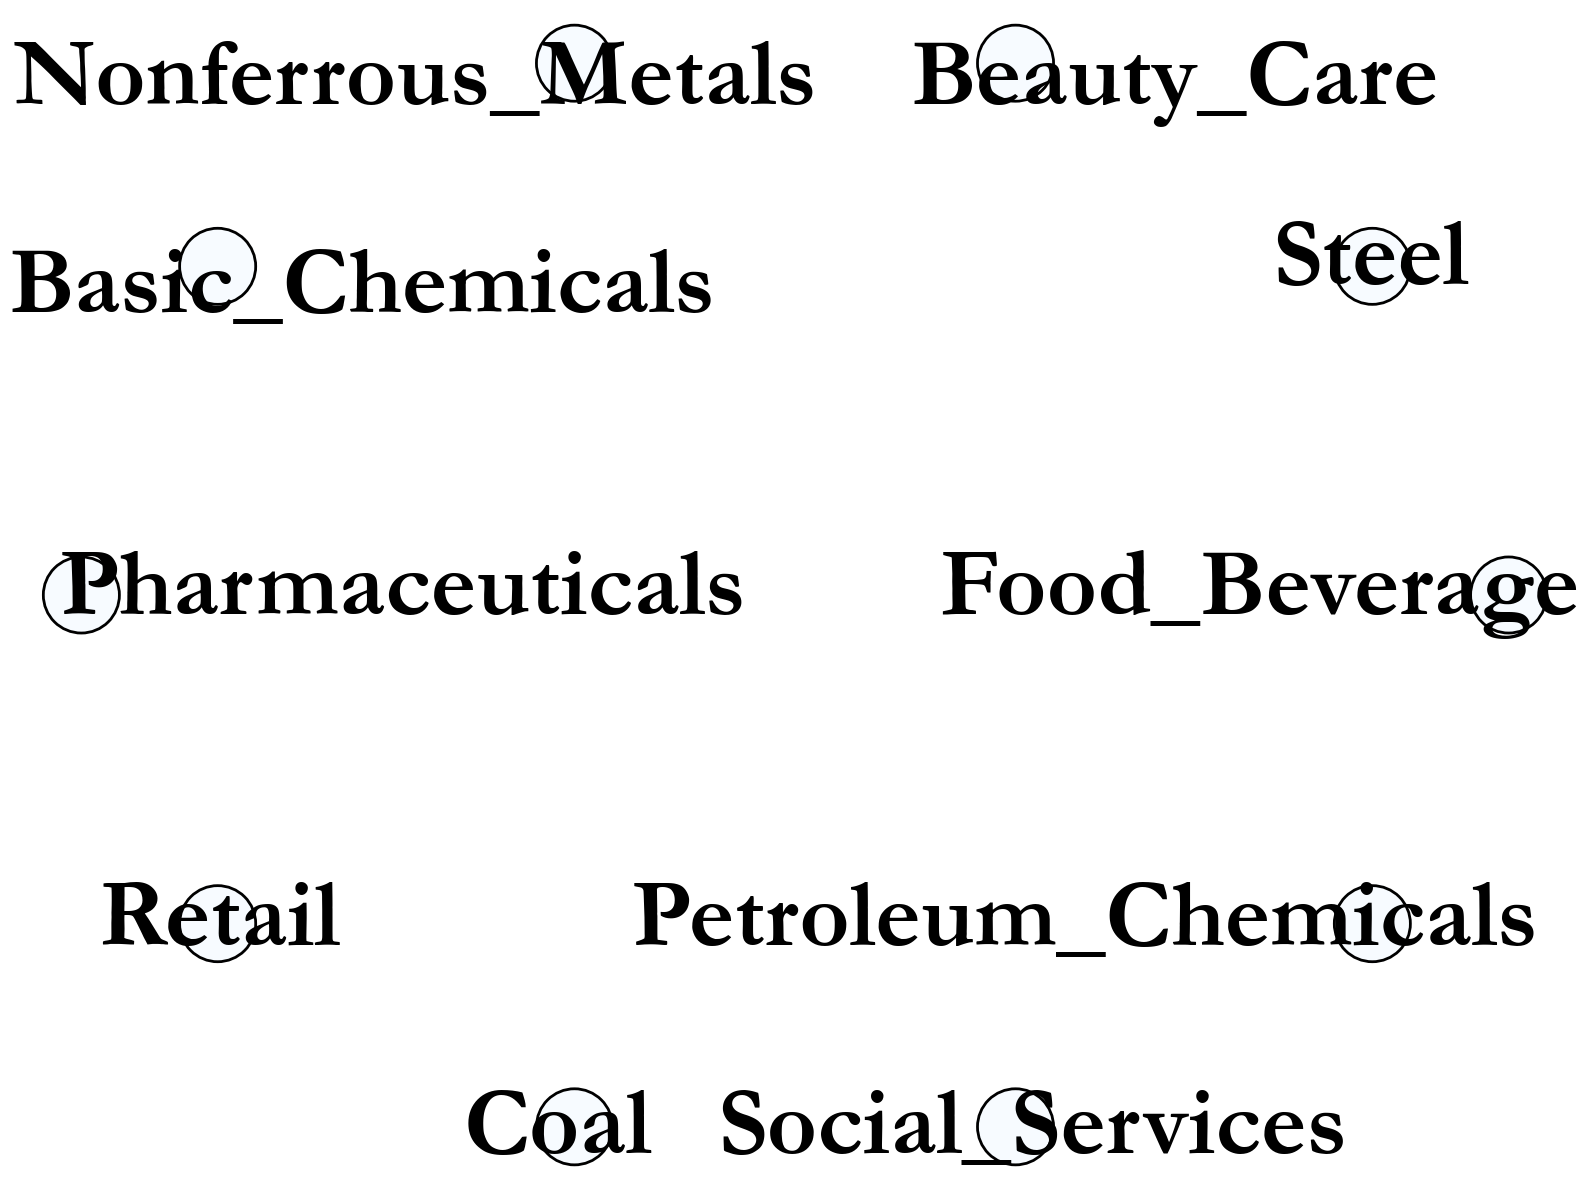

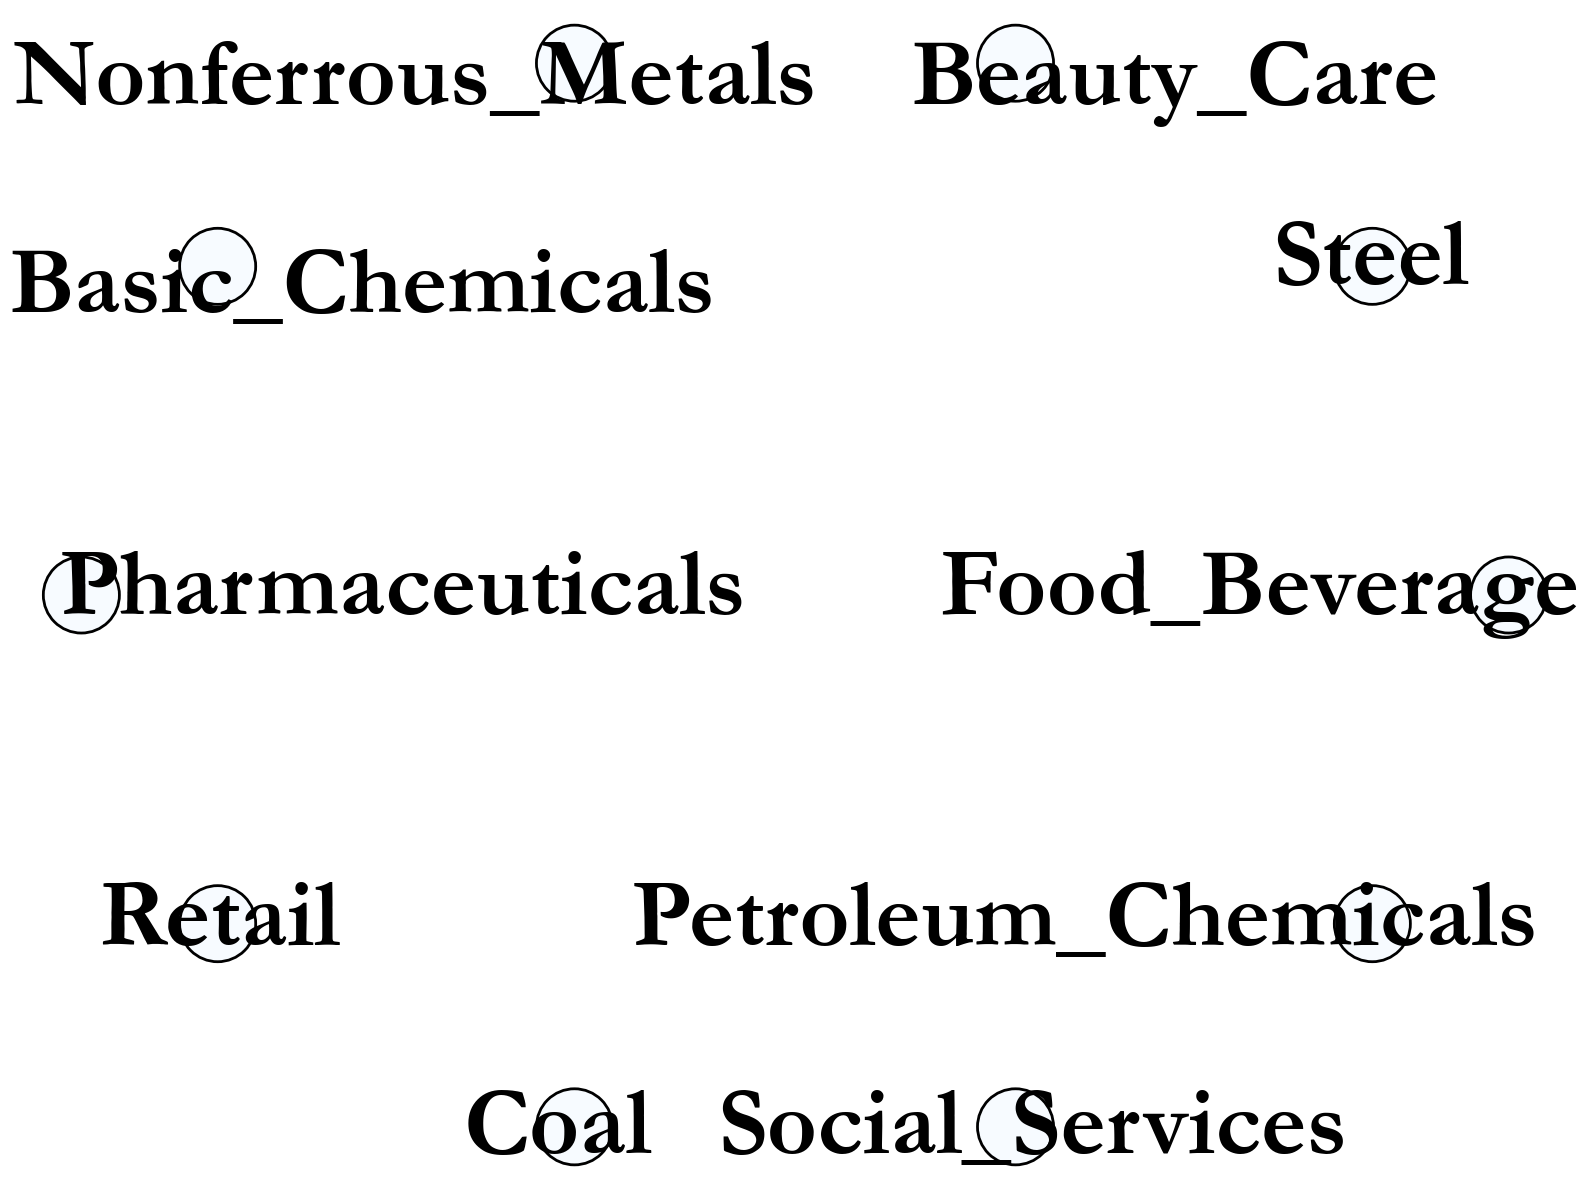

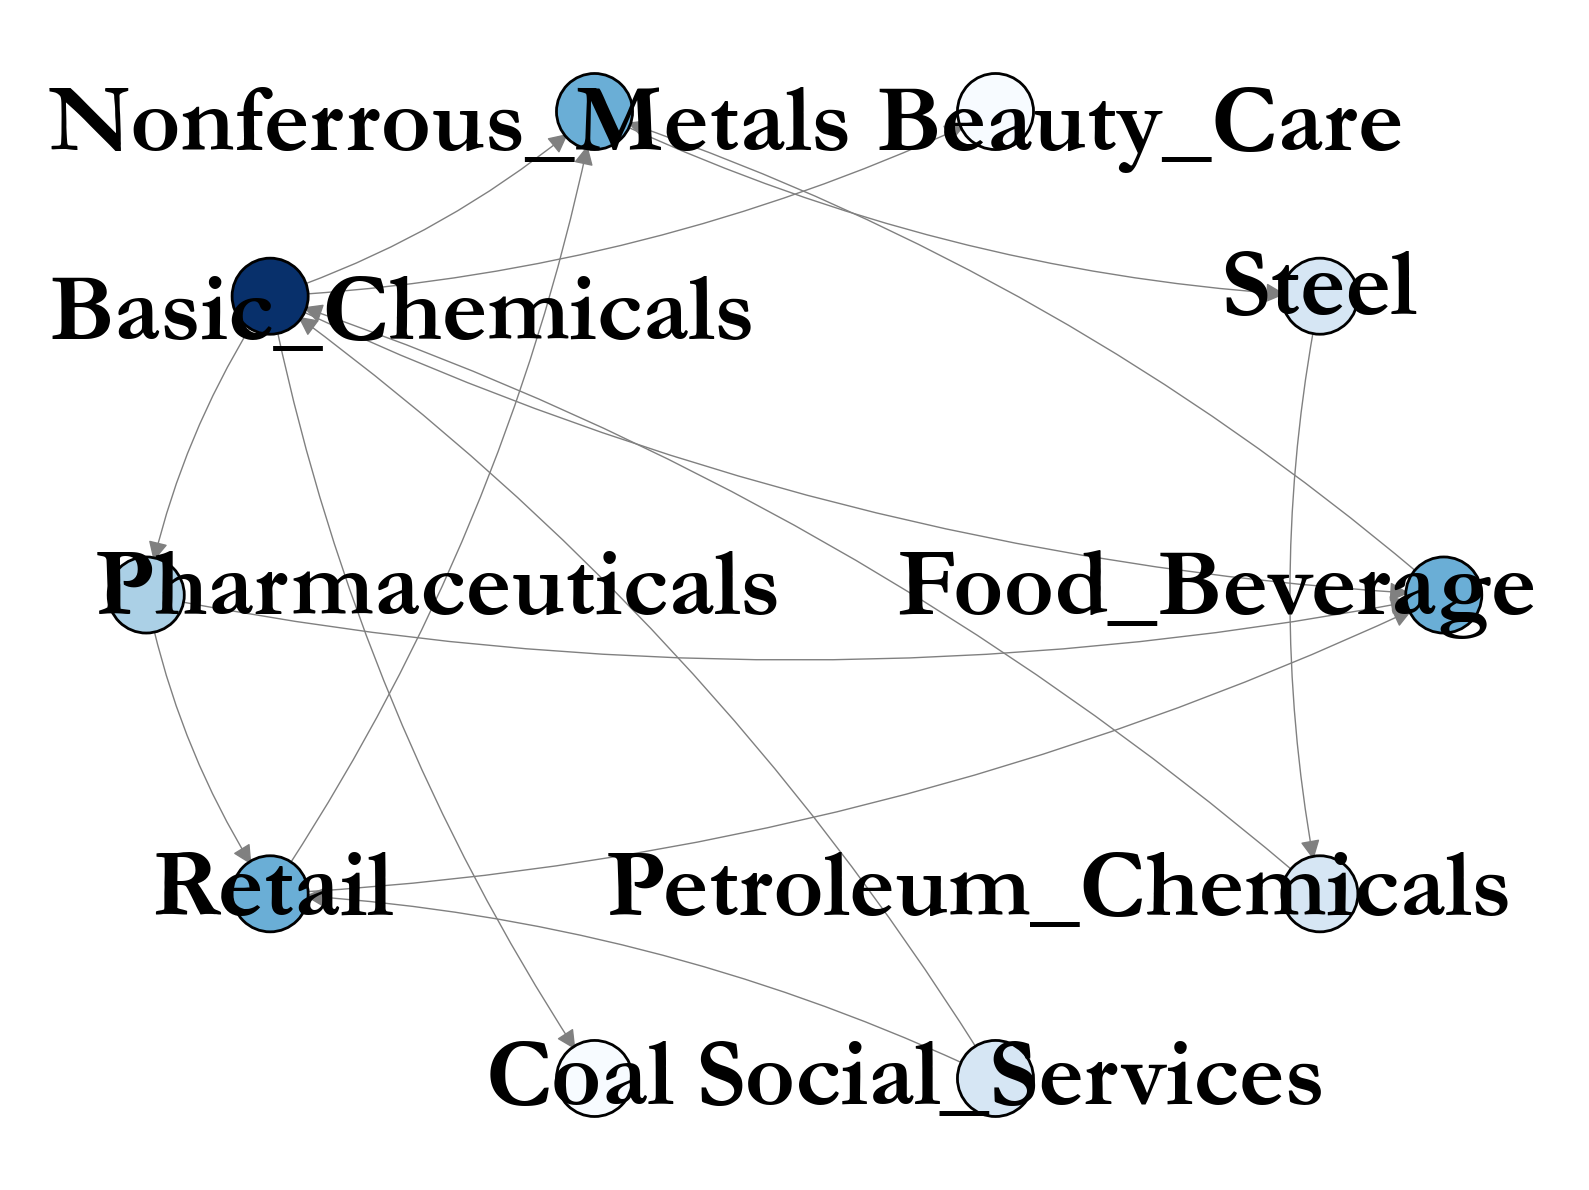

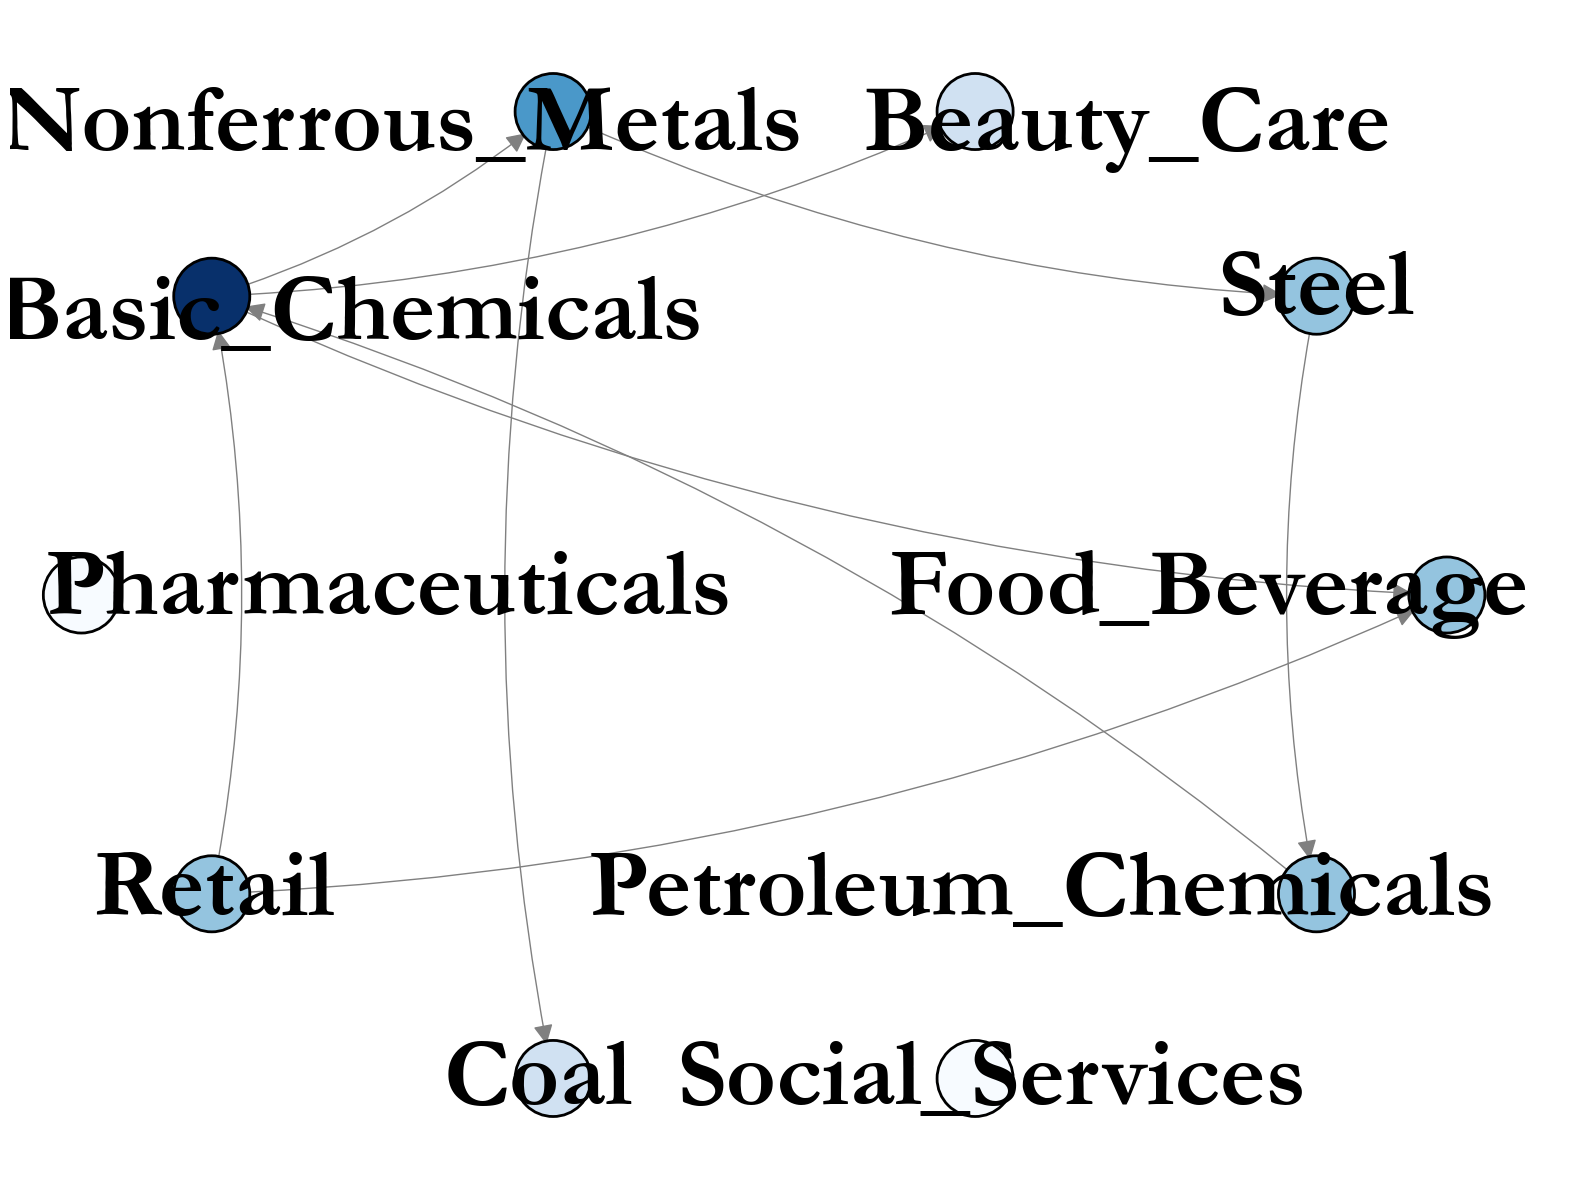

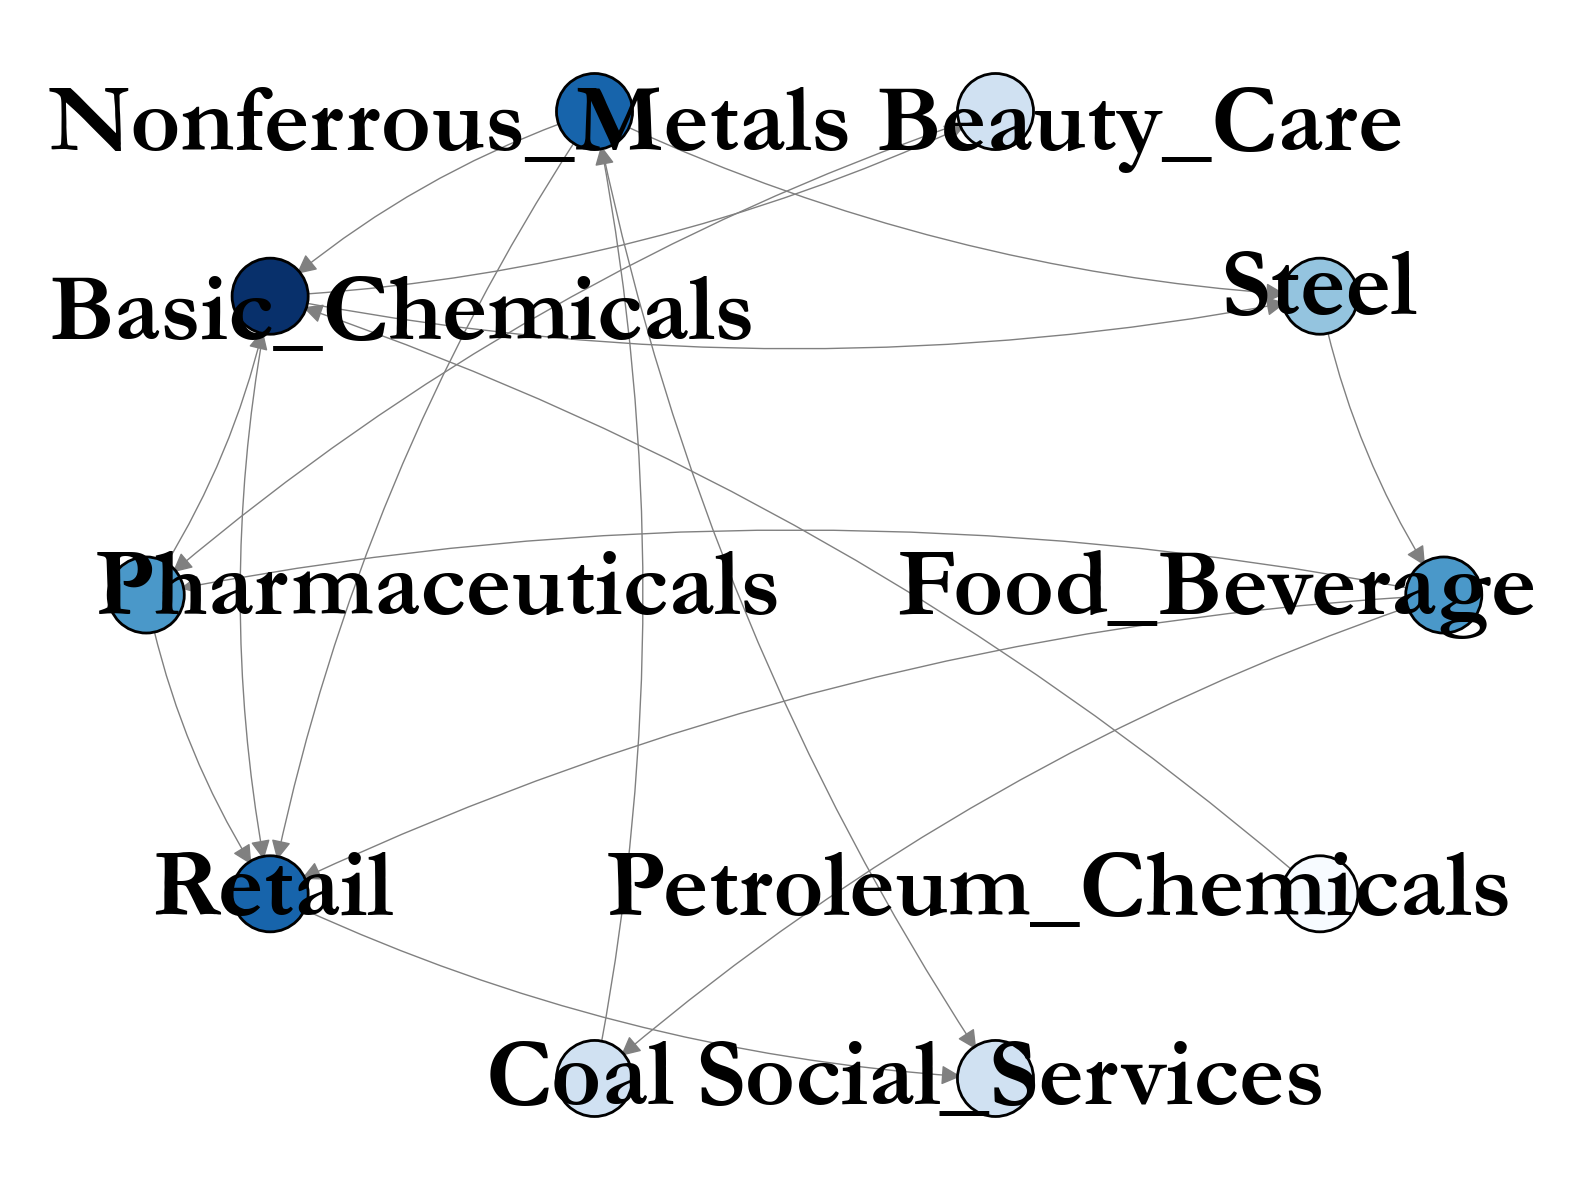

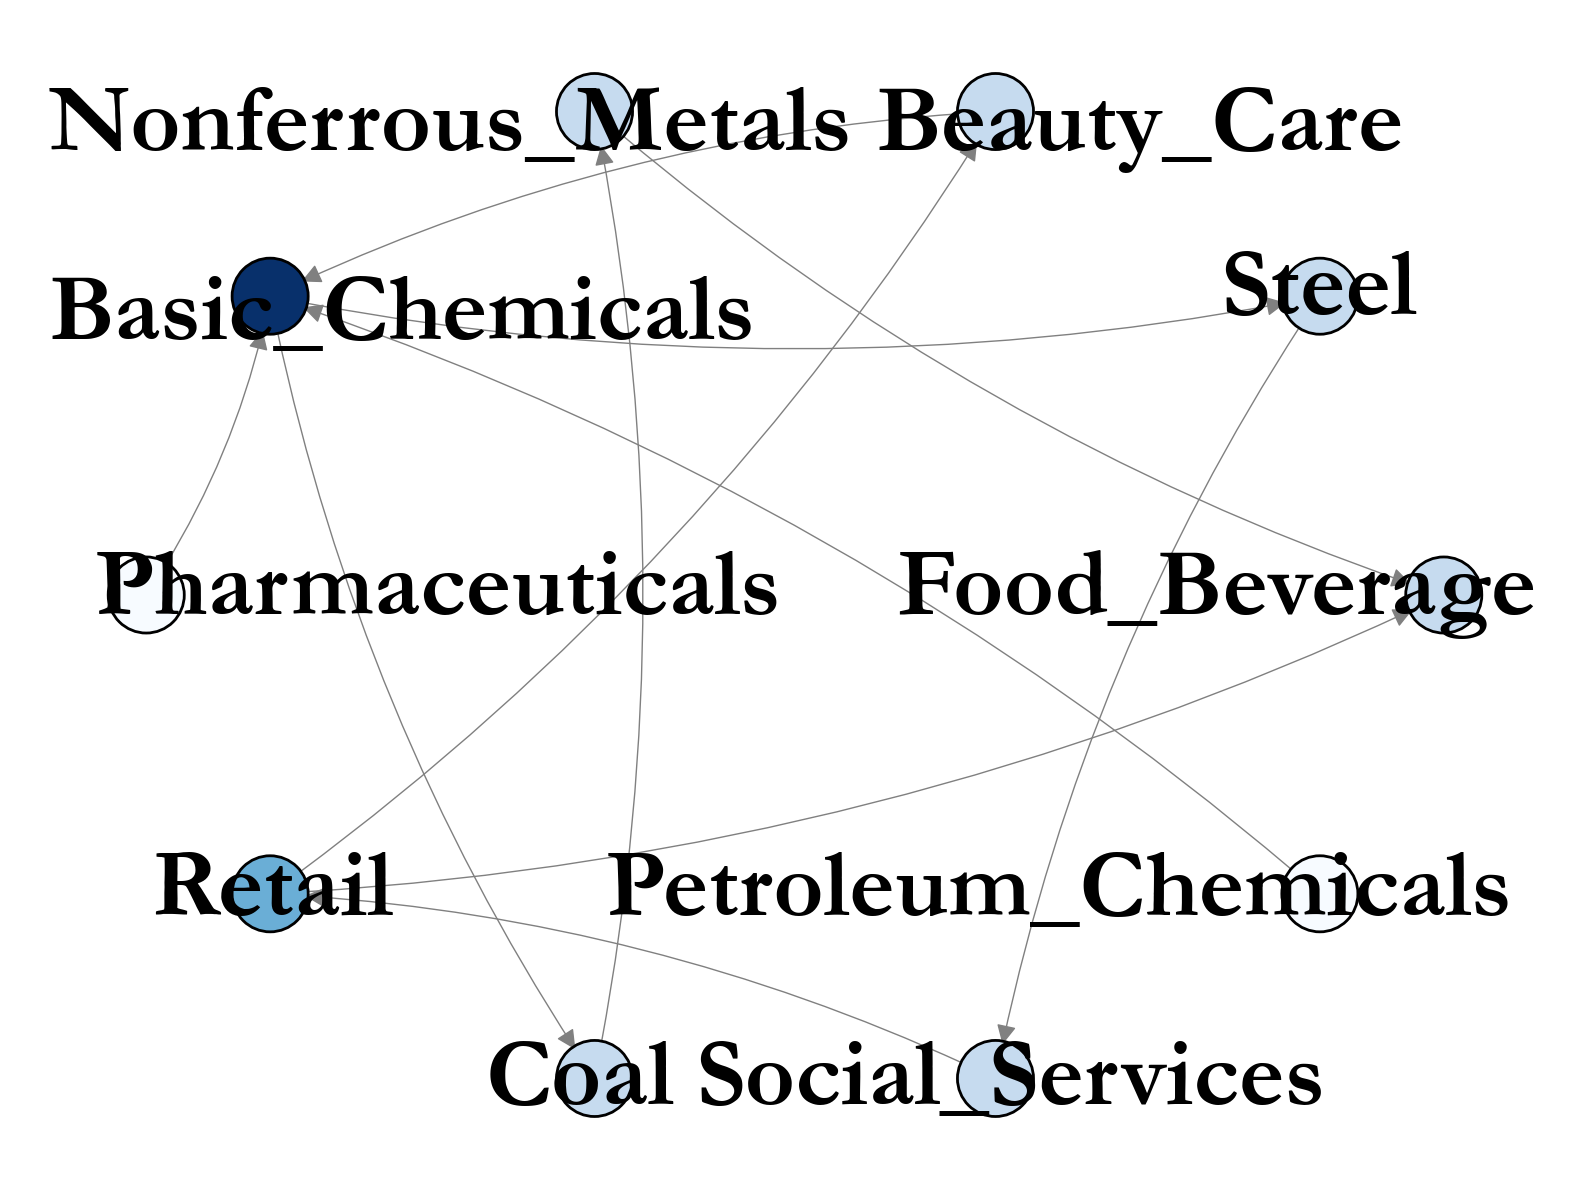

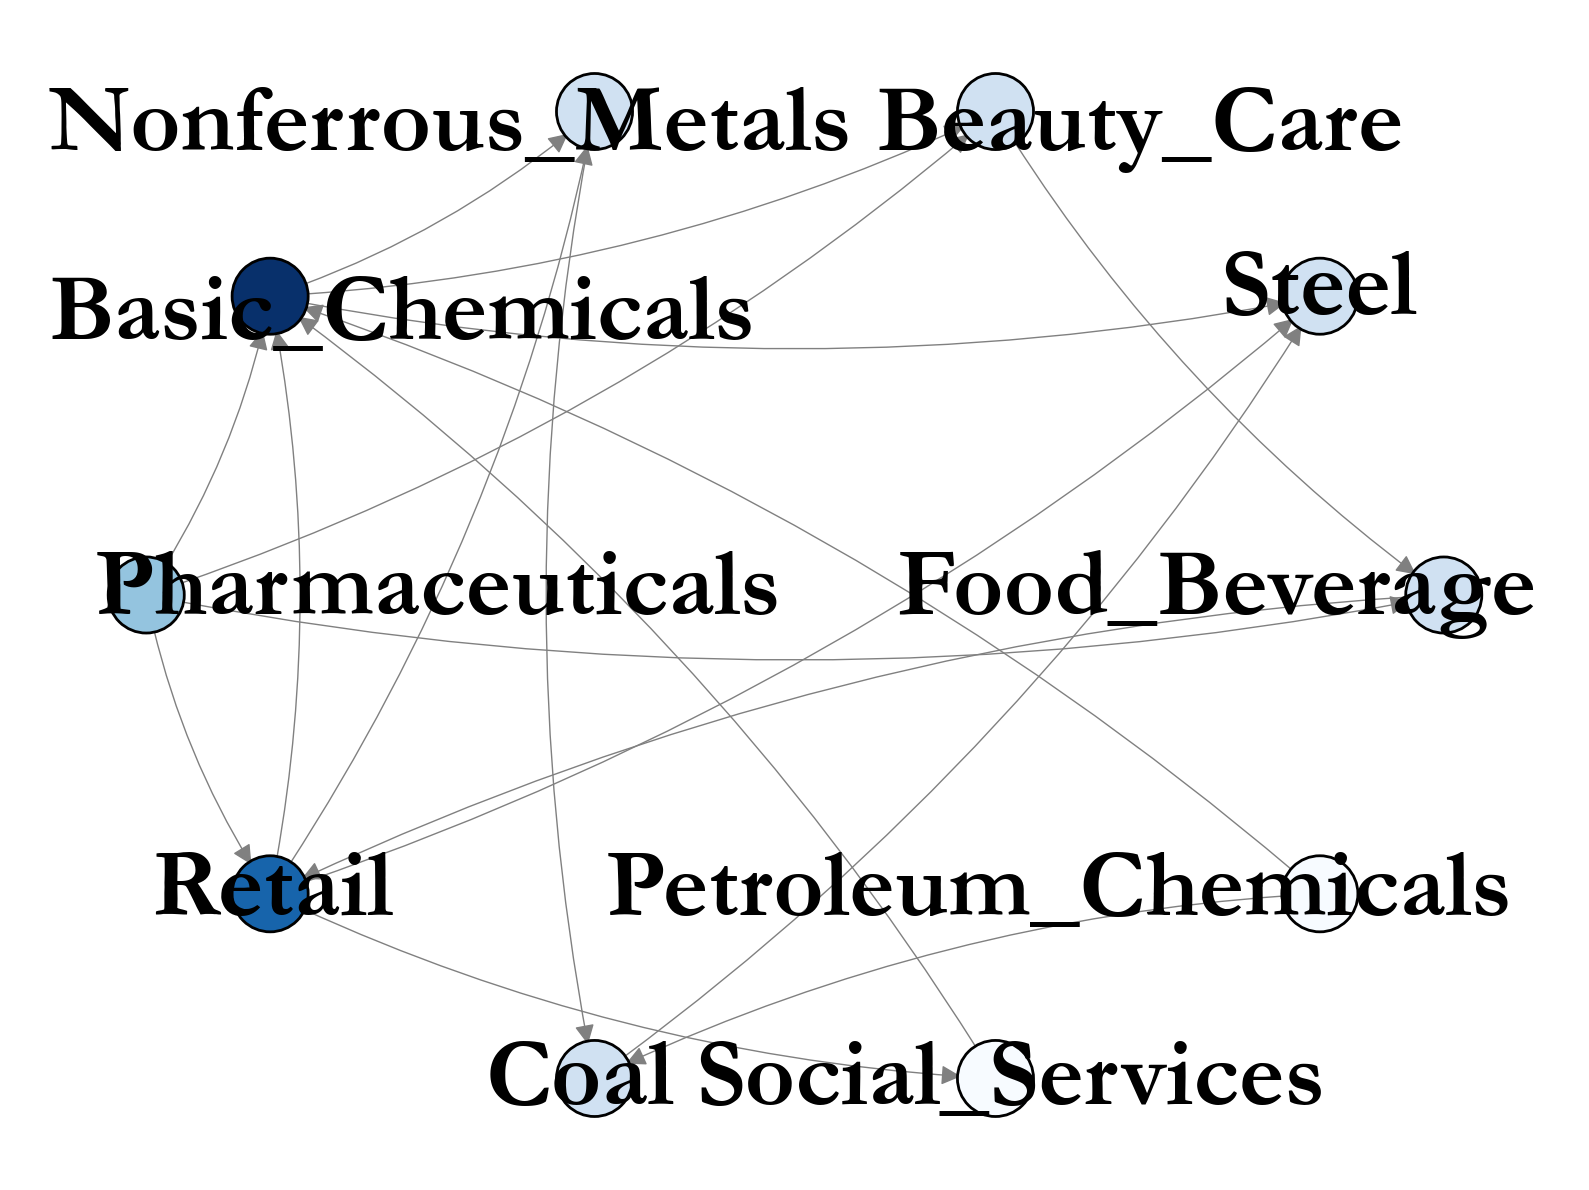

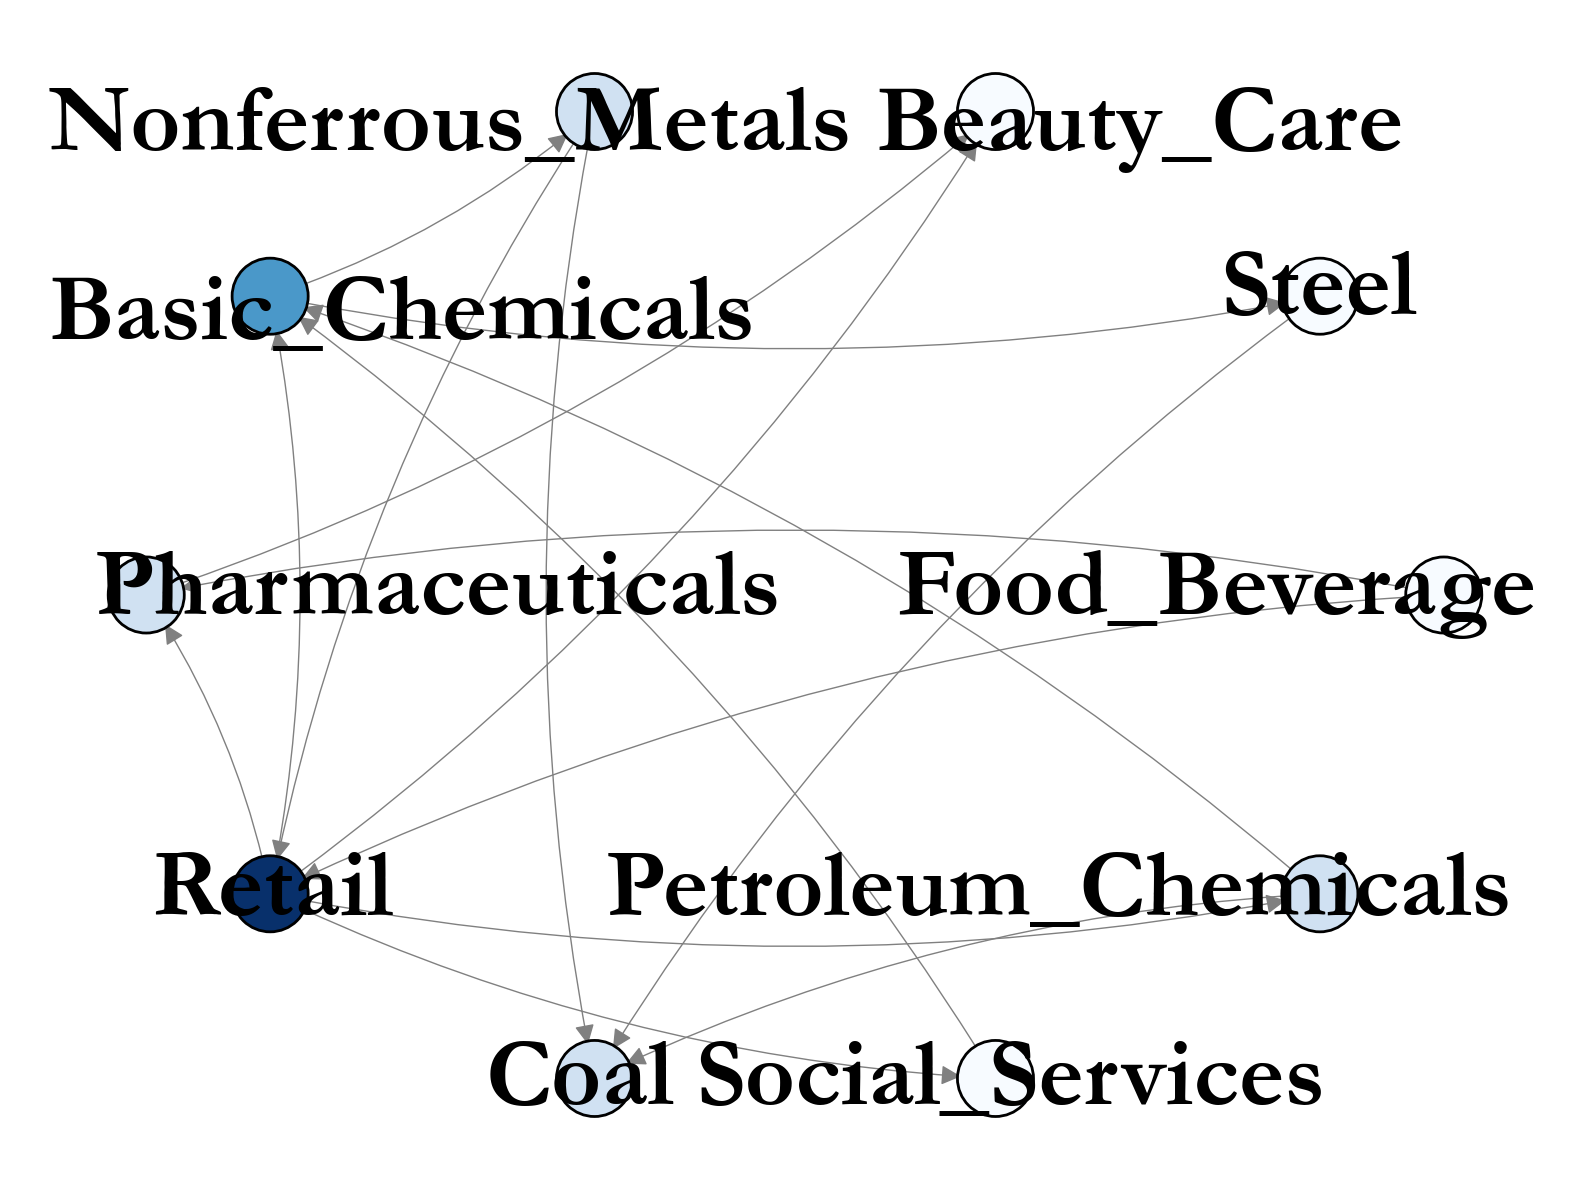

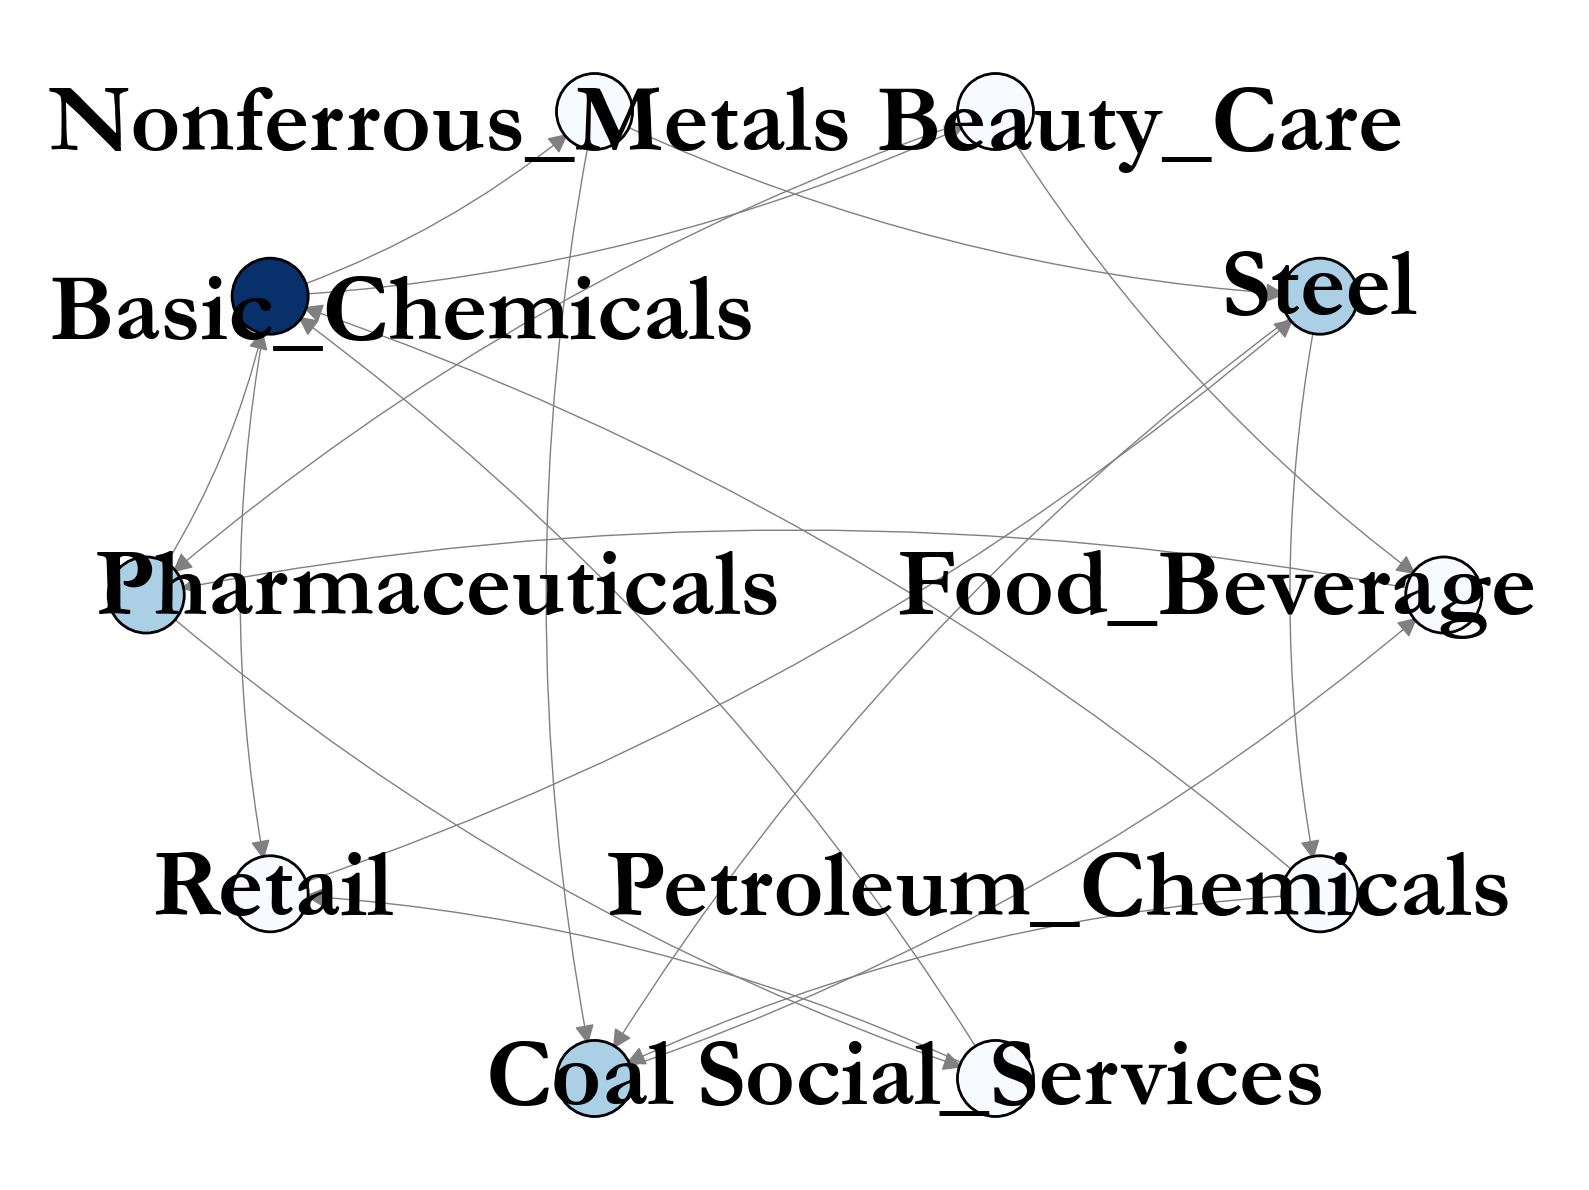

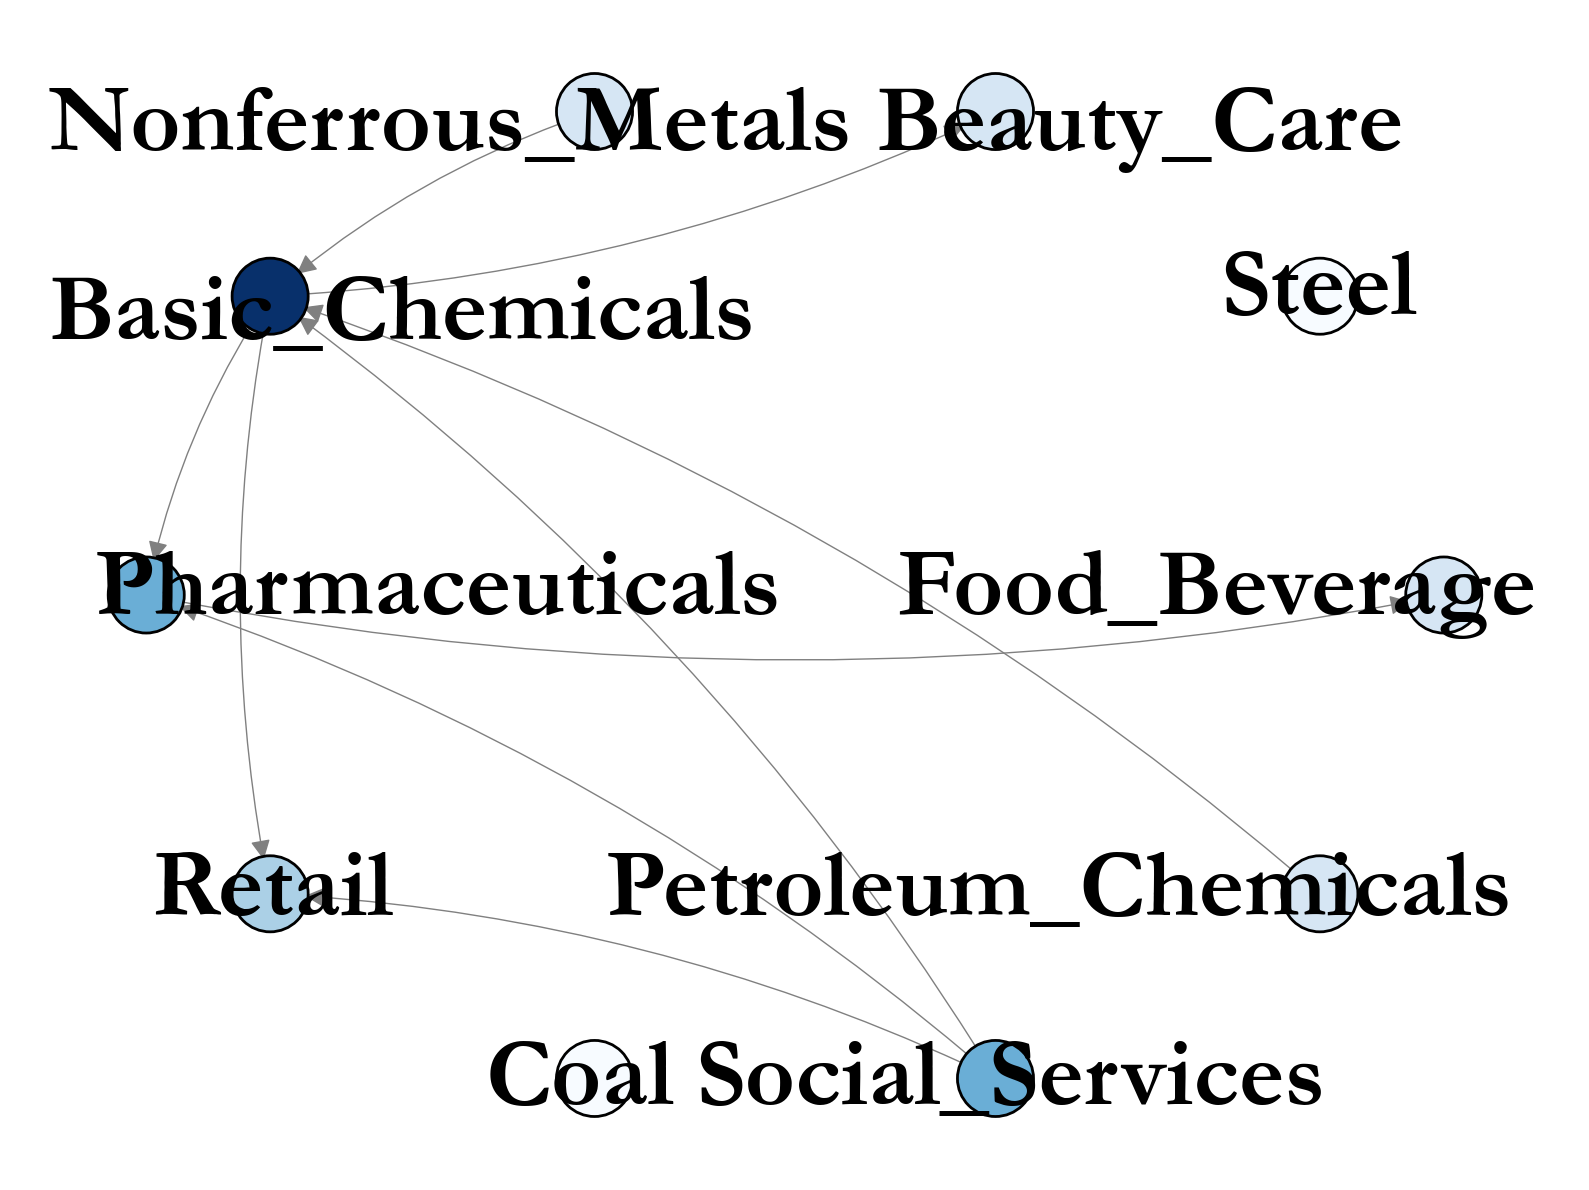

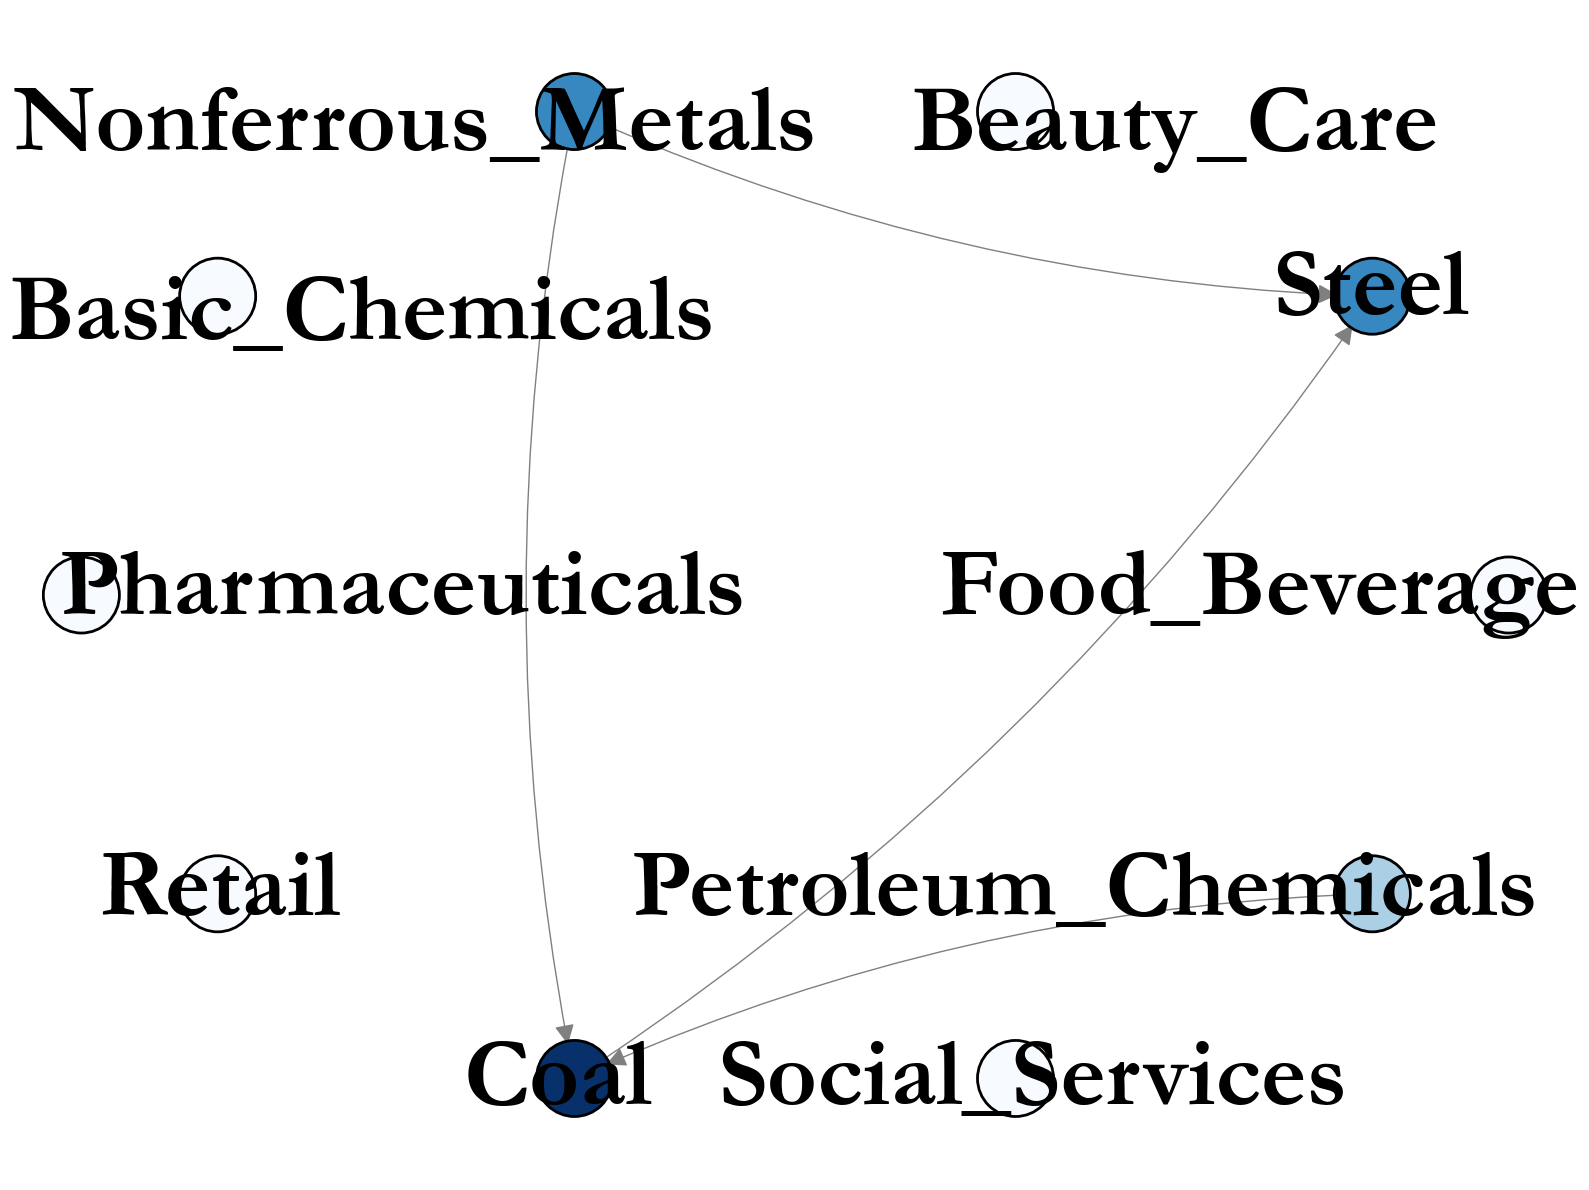

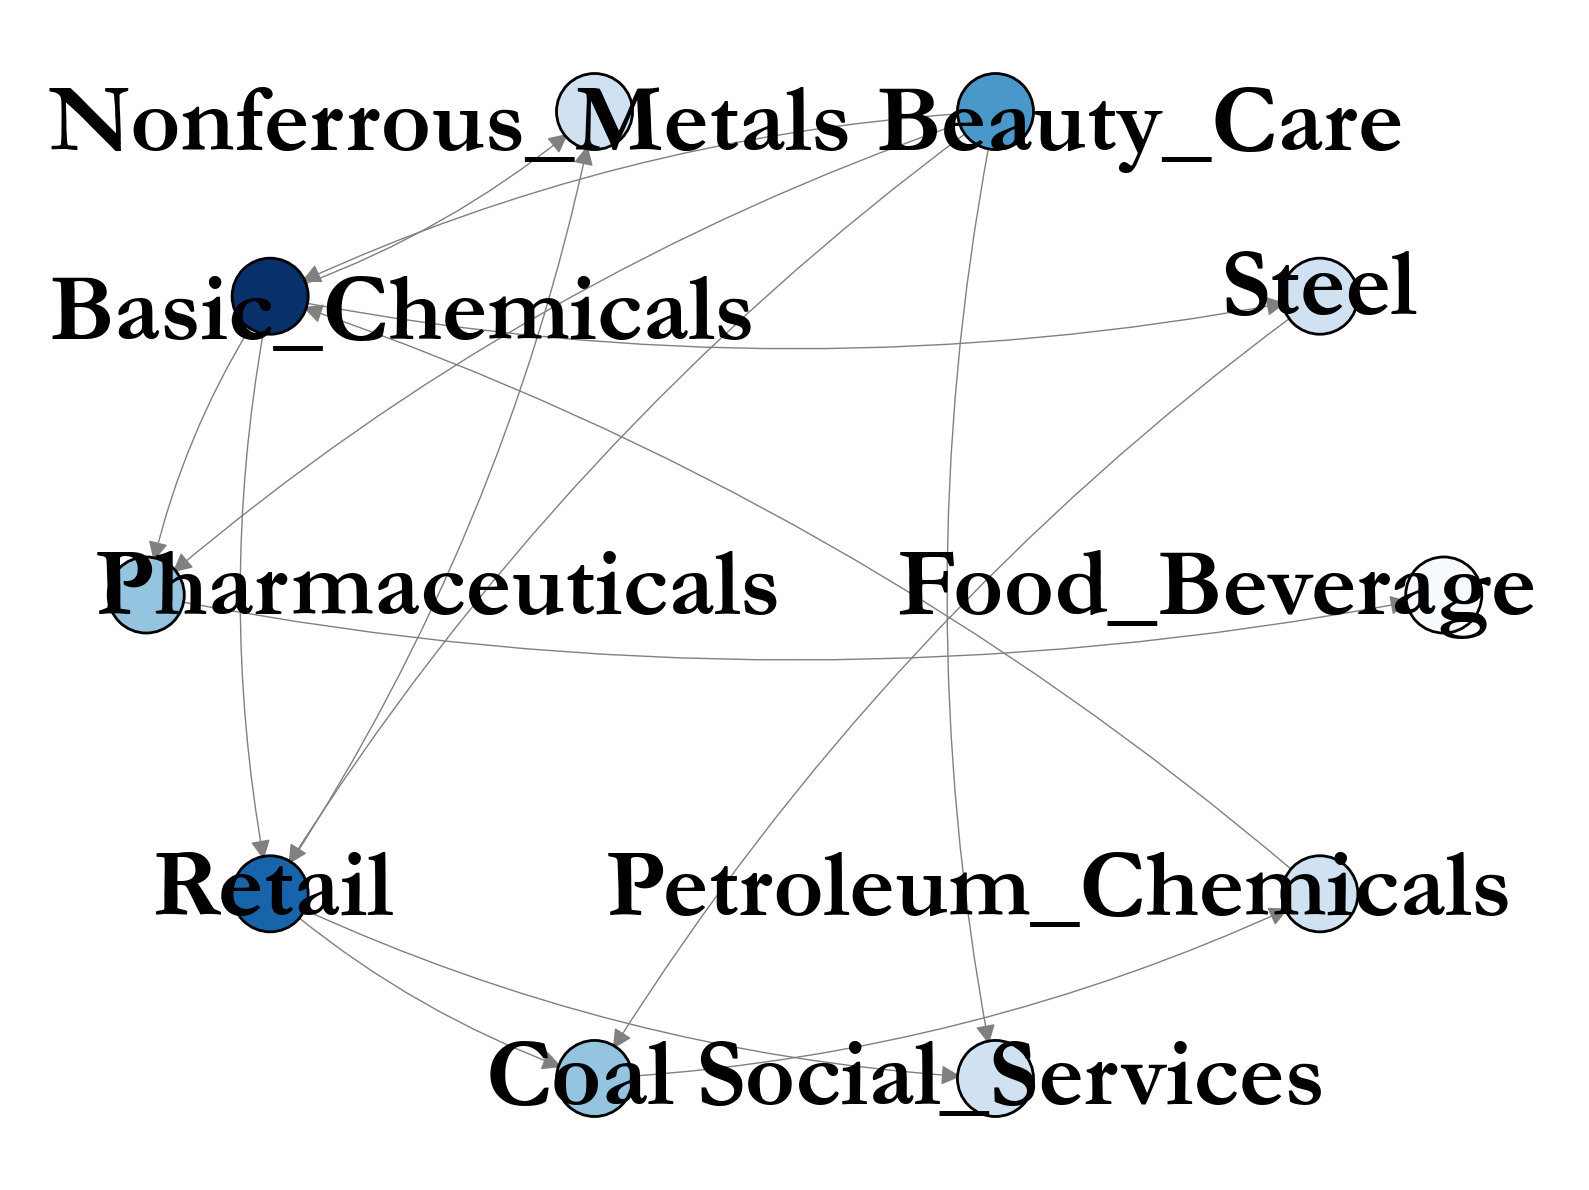

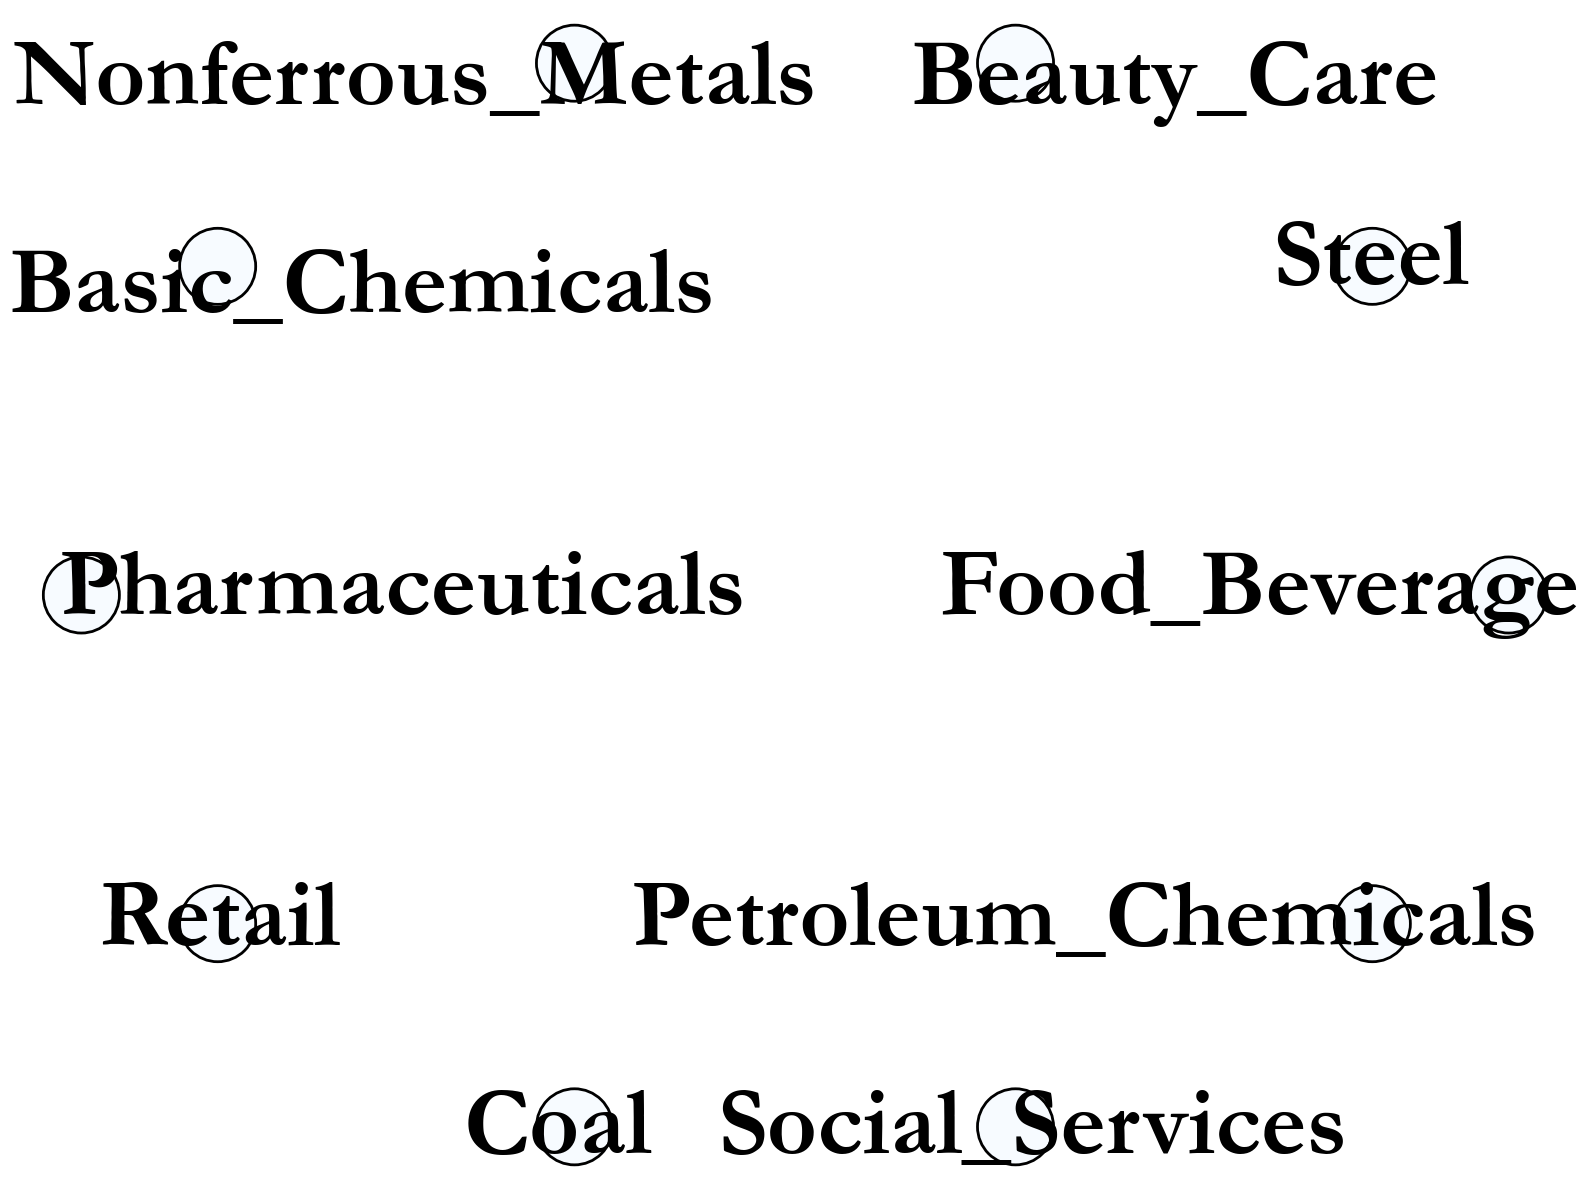

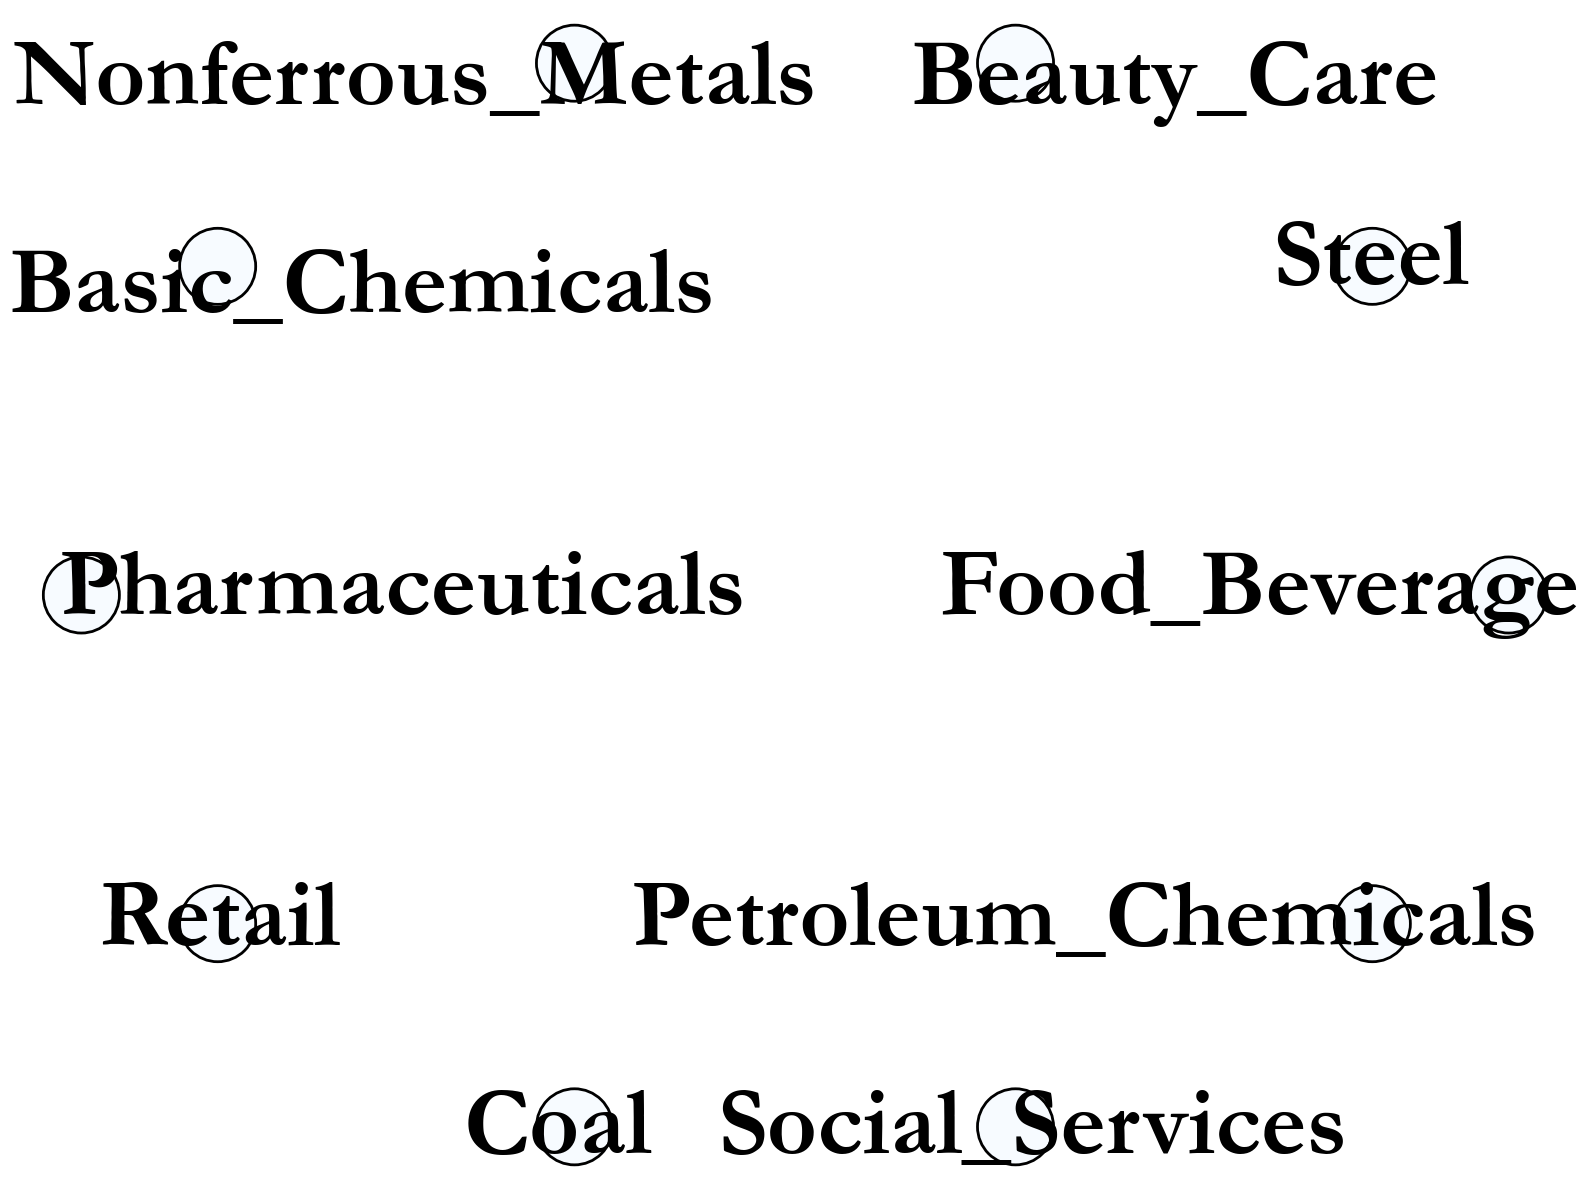

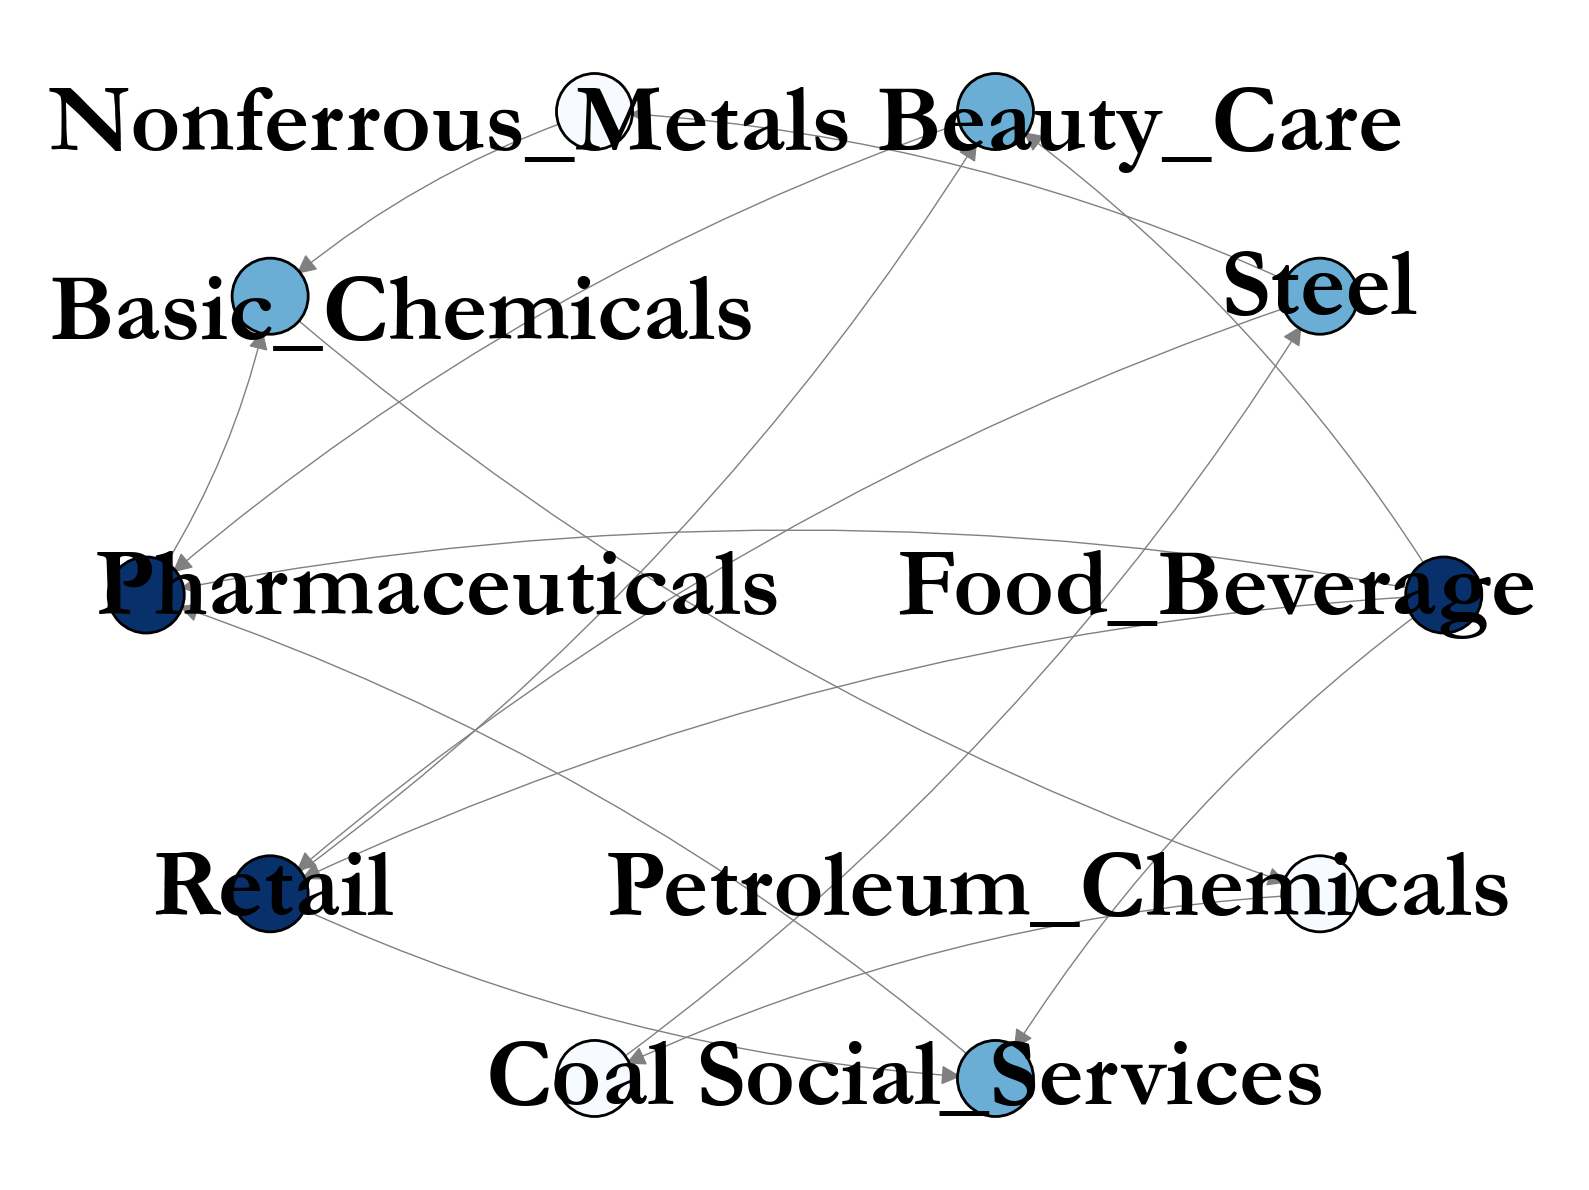

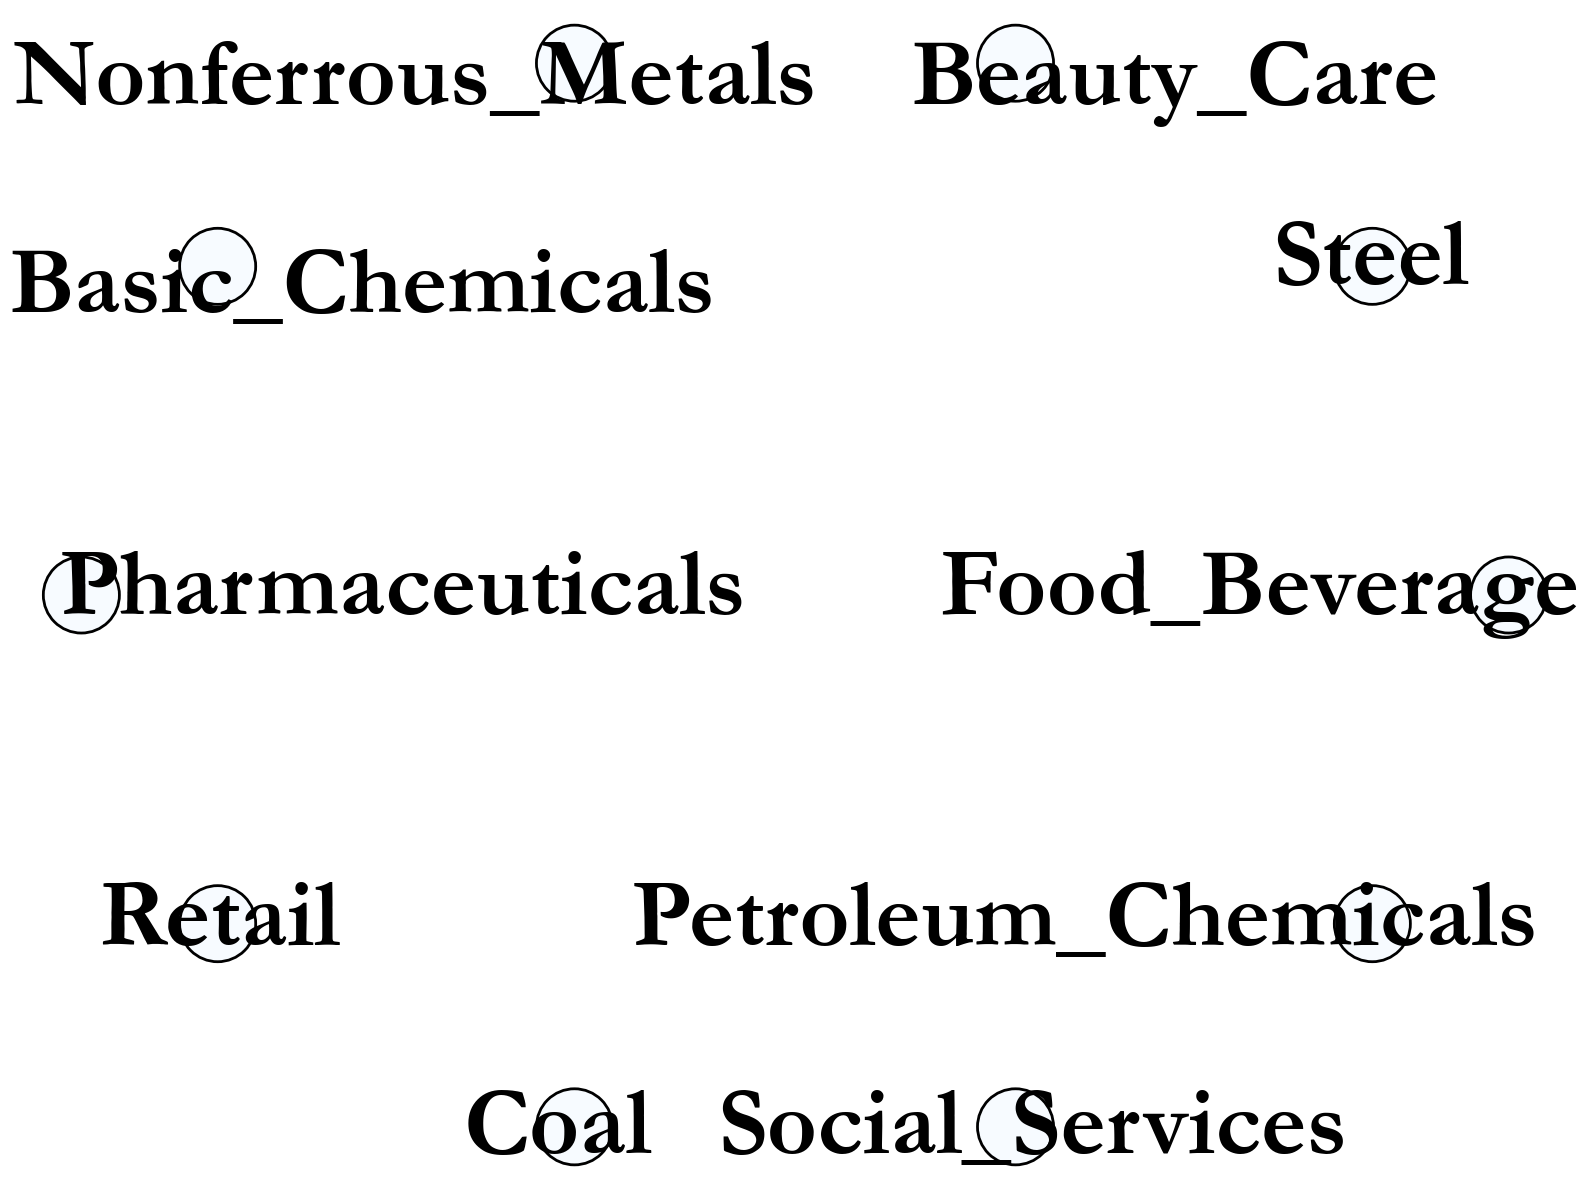

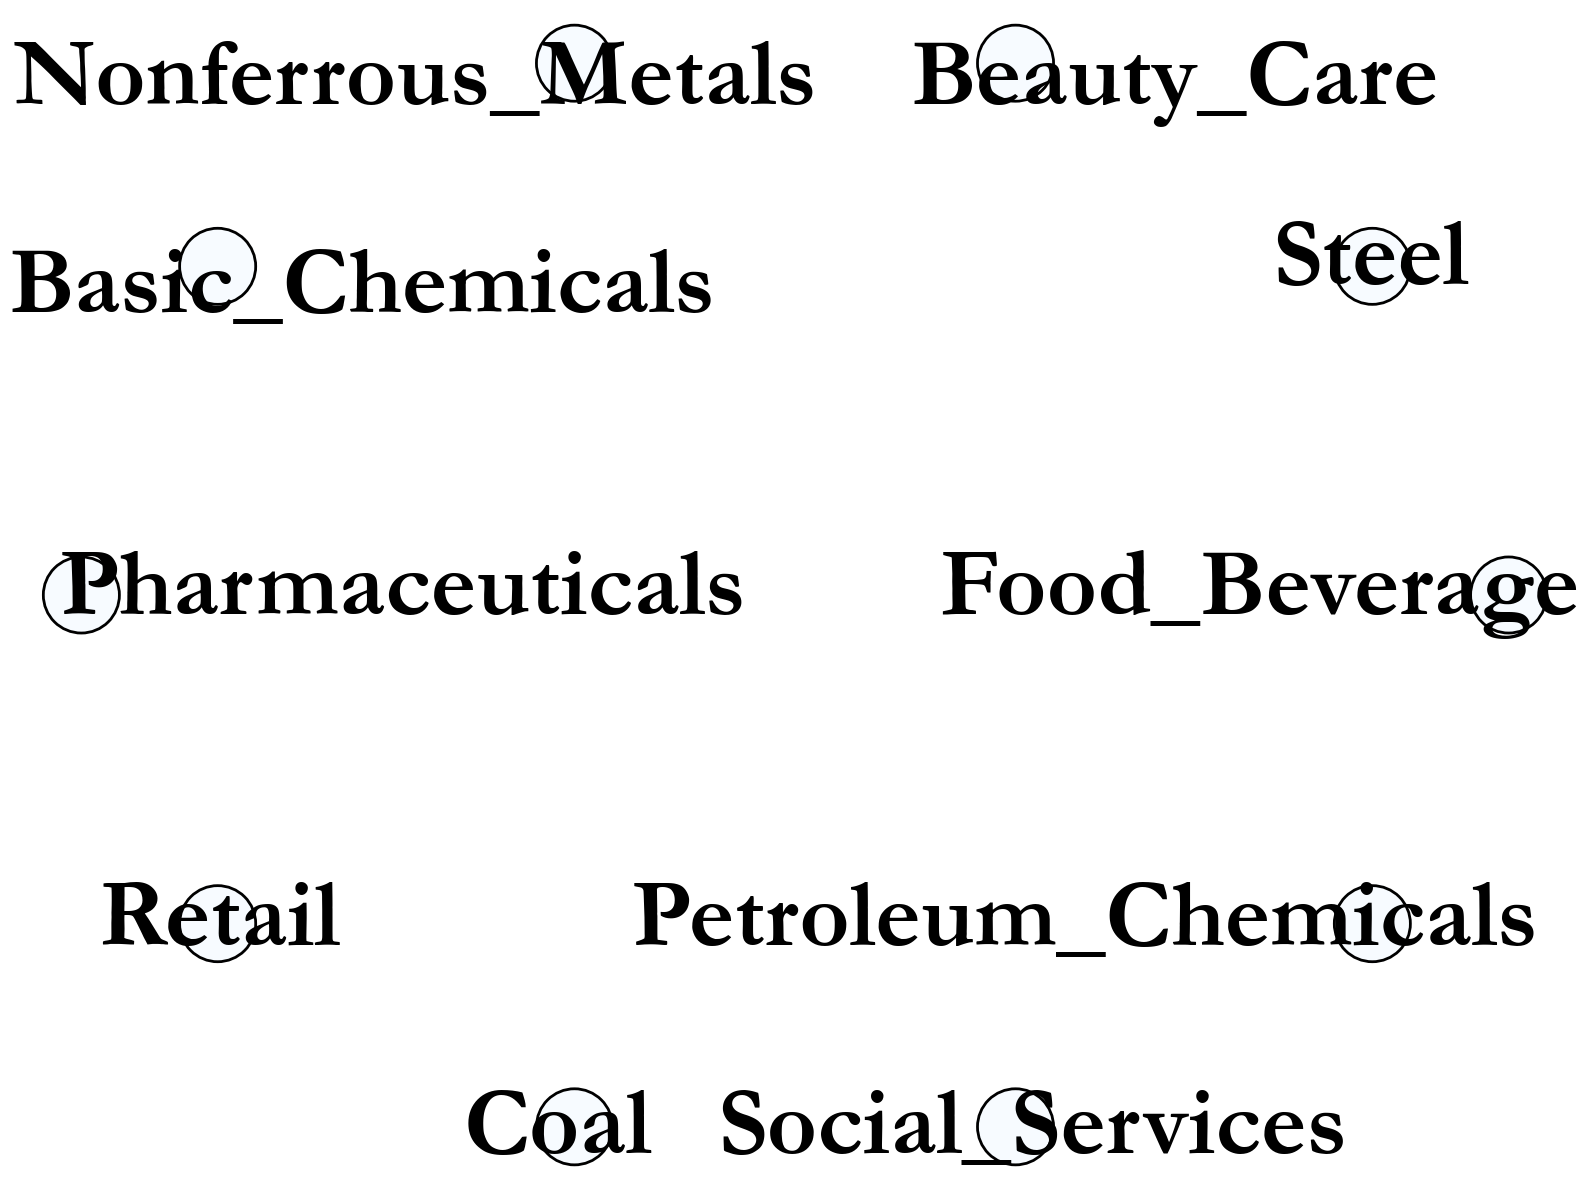

In [ ]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体为 Garamond
rcParams['font.family'] = 'Garamond'

# Step 1: 加载存储的网络
with open('stored_networks.pkl', 'rb') as f:
    stored_networks = pickle.load(f)

# Step 2: 遍历存储的每个时间段网络并绘制图
for time_period, graph_nx in stored_networks.items():
    # 设置图形大小，调整为更大的尺寸
    plt.figure(figsize=(16,12))  # 更宽大一些的图形尺寸
    
    # 使用圆形布局计算节点位置
    pos = nx.circular_layout(graph_nx)  # 使用圆形布局
    
    # 调整节点位置，紧凑化（通过缩小布局半径）
    pos = {node: (x * 0.1, y * 0.1) for node, (x, y) in pos.items()}  # 缩小半径，紧凑布局
    
    # 绘制网络节点，增加节点的颜色渐变
    node_color = [graph_nx.degree(node) for node in graph_nx.nodes()]  # 根据节点度数设置颜色
    nx.draw_networkx_nodes(
        graph_nx, pos, 
        node_size=3000, node_color=node_color, cmap=plt.cm.Blues, edgecolors='black', linewidths=2
    )
    
    # 绘制网络边，调整箭头样式
    nx.draw_networkx_edges(
        graph_nx, pos, 
        edge_color='gray', arrows=True, 
        arrowstyle='-|>', arrowsize=30,  # 增大箭头大小
        connectionstyle="arc3,rad=0.1", 
        min_source_margin=25, min_target_margin=25
    )
    
    # 绘制节点标签，确保使用 Garamond 字体，字体大小增大
    labels = {node: node for node in graph_nx.nodes()}  # 显示节点标签
    
    # 调整标签的位置，使其更靠近节点中心
    label_pos = {node: (x, y) for node, (x, y) in pos.items()}
    
    # 调整标签偏移量来避免溢出
    label_offset = 0.25  # 向中心靠拢的偏移量
    label_pos = {node: (x * (1 - label_offset), y * (1 - label_offset)) for node, (x, y) in label_pos.items()}

    # 特别修改某些节点的标签位置
    special_node = 'Nonferrous_Metals'  # 假设我们想调整 'Node1' 节点的标签位置
    if special_node in label_pos:
        # 修改 'Node1' 标签位置，可以往右、左、上、下微调
        label_pos[special_node] = (label_pos[special_node][0] - 0.03, label_pos[special_node][1] + 0.02)
    
    # 另一个特定节点调整示例：'Beauty_Care'
    special_node2 = 'Beauty_Care'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] + 0.03 , label_pos[special_node2][1] + 0.02)

    # 另一个特定节点调整示例：'Basic_Chemicals'
    special_node2 = 'Basic_Chemicals'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0]  , label_pos[special_node2][1] + 0.01)

    # 另一个特定节点调整示例：'Retail'
    special_node2 = 'Retail'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] - 0.02  , label_pos[special_node2][1] - 0.015)

    # 另一个特定节点调整示例：'Coal'
    special_node2 = 'Coal'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] - 0.01  , label_pos[special_node2][1] - 0.025)
    
    # 另一个特定节点调整示例：'Social_Services'
    special_node2 = 'Social_Services'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] + 0.01   , label_pos[special_node2][1] - 0.025)

    # 另一个特定节点调整示例：'Petroleum_Chemicals'
    special_node2 = 'Petroleum_Chemicals'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] - 0.02   , label_pos[special_node2][1] - 0.015)

    # 另一个特定节点调整示例：'Steel'
    special_node2 = 'Steel'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] + 0.02   , label_pos[special_node2][1] + 0.015)

    # 另一个特定节点调整示例：'Steel'
    special_node2 = 'Pharmaceuticals'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] +0.02  , label_pos[special_node2][1] )

    # 另一个特定节点调整示例：'Steel'
    special_node2 = 'Food_Beverage'
    if special_node2 in label_pos:
        # 'Node2' 标签位置往上调整
        label_pos[special_node2] = (label_pos[special_node2][0] - 0.01  , label_pos[special_node2][1] )

    
    # 绘制节点标签
    nx.draw_networkx_labels(
        graph_nx, label_pos, labels, 
        font_size=70, font_color='black', font_family='Garamond', font_weight='bold'  # 增大字体大小并加粗
    )

    # 添加标题，字体放大
    # plt.title(f'Network for {time_period}', fontsize=80, fontweight='bold', pad=40)  # 增大标题字体
    
    # 关闭坐标轴，去掉不必要的视觉元素
    plt.axis('off')
    
    # 调整图像布局以适应内容
    plt.tight_layout()

    # 保存为高清PDF
    plt.savefig(f"PCMCI_network_{time_period.replace(' ', '_').replace('~', '_')}.pdf", dpi=1200, bbox_inches='tight')

    # 显示图像,要先存储再显示，不然先显示会清除图像内容
    plt.show()



In [14]:
import pickle
import pandas as pd
import networkx as nx

# Step 1: 加载存储的网络
with open('stored_networks.pkl', 'rb') as f:
    stored_networks = pickle.load(f)

# Step 2: 加载因子数据
pe_data = pd.read_excel('factors.xlsx', sheet_name='PE')  # PE 因子
dy_data = pd.read_excel('factors.xlsx', sheet_name='DY')  # DY 因子
mv_data = pd.read_excel('factors.xlsx', sheet_name='MV')  # MV 因子

# 转换日期为 datetime
pe_data['Date'] = pd.to_datetime(pe_data['Date'])
dy_data['Date'] = pd.to_datetime(dy_data['Date'])
mv_data['Date'] = pd.to_datetime(mv_data['Date'])

# 定义显著行业列表
selected_industries = [
    'Food_Beverage', 'Steel', 'Beauty_Care', 'Nonferrous_Metals',
    'Basic_Chemicals', 'Pharmaceuticals', 'Retail', 'Coal',
    'Social_Services', 'Petroleum_Chemicals'
]

# 定义时间节点和阶段
time_periods = [
    ('1999-09', '2000-12', 'Overheat'),
    ('2000-12', '2001-03', 'Recovery'),
    ('2001-03', '2002-04', 'Reflation'),
    ('2002-04', '2003-06', 'Stagflation'),
    ('2003-06', '2004-07', 'Overheat'),
    ('2004-07', '2006-03', 'Reflation'),
    ('2006-03', '2008-03', 'Overheat'),
    ('2008-03', '2009-06', 'Reflation'),
    ('2009-06', '2011-09', 'Overheat'),
    ('2011-09', '2016-03', 'Reflation'),
    ('2016-03', '2017-02', 'Recovery'),
    ('2017-02', '2018-09', 'Overheat'),
    ('2018-09', '2020-03', 'Stagflation'),
    ('2020-03', '2020-11', 'Recovery'),
    ('2020-11', '2021-06', 'Overheat'),
    ('2021-06', '2022-09', 'Stagflation'),
    ('2022-09', '2024-01', 'Reflation'),
    ('2024-01', '2024-11', 'Stagflation')
]
time_periods = [(pd.to_datetime(start), pd.to_datetime(end), label) for start, end, label in time_periods]

# Step 3: 计算每个时间段的平均 PE、DY 和 MV
pe_averages = {}
dy_averages = {}
mv_averages = {}

for start, end, phase_label in time_periods:
    time_period_label = f"{start.strftime('%Y-%m')} ~ {end.strftime('%Y-%m')}"
    pe_period = pe_data[(pe_data['Date'] >= start) & (pe_data['Date'] <= end)].mean(numeric_only=True)
    dy_period = dy_data[(dy_data['Date'] >= start) & (dy_data['Date'] <= end)].mean(numeric_only=True)
    mv_period = mv_data[(mv_data['Date'] >= start) & (mv_data['Date'] <= end)].mean(numeric_only=True)
    pe_averages[time_period_label] = pe_period
    dy_averages[time_period_label] = dy_period
    mv_averages[time_period_label] = mv_period

# Step 4: 初始化面板数据
panel_data = []
nodes = selected_industries  # 使用显著行业

for (start, end, phase_label) in time_periods:
    time_period_label = f"{start.strftime('%Y-%m')} ~ {end.strftime('%Y-%m')}"
    graph_nx = stored_networks.get(time_period_label, nx.DiGraph())  # 默认空图
    pagerank_scores = nx.pagerank(graph_nx) if len(graph_nx) > 0 else {}

    # 网络整体属性
    density = nx.density(graph_nx) if len(graph_nx) > 0 else 0
    avg_clustering = nx.average_clustering(graph_nx.to_undirected()) if len(graph_nx) > 0 else 0
    avg_shortest_path = nx.average_shortest_path_length(graph_nx) if len(graph_nx) > 0 and nx.is_strongly_connected(graph_nx) else 0

    # 遍历显著行业的 (source, target) 组合
    for source in nodes:
        for target in nodes:
            if source != target:  # 排除自环
                # 检查是否存在边
                connection = 1 if graph_nx.has_edge(source, target) else 0

                # 计算标准化的出度和入度中心性
                out_degree_source = graph_nx.out_degree(source) / (len(nodes) - 1) if source in graph_nx else 0
                in_degree_source = graph_nx.in_degree(source) / (len(nodes) - 1) if source in graph_nx else 0
                out_degree_target = graph_nx.out_degree(target) / (len(nodes) - 1) if target in graph_nx else 0
                in_degree_target = graph_nx.in_degree(target) / (len(nodes) - 1) if target in graph_nx else 0

                # 出度中心性和入度中心性之差
                out_degree_diff = out_degree_source - out_degree_target
                in_degree_diff = in_degree_source - in_degree_target

                # 获取 PageRank
                pagerank_source = pagerank_scores.get(source, 0)
                pagerank_target = pagerank_scores.get(target, 0)

                # 计算 PE_diff, DY_diff, MV_diff
                pe_diff = (pe_averages[time_period_label][source] - pe_averages[time_period_label][target]
                           if source in pe_averages[time_period_label].index and target in pe_averages[time_period_label].index
                           else None)
                dy_diff = (dy_averages[time_period_label][source] - dy_averages[time_period_label][target]
                           if source in dy_averages[time_period_label].index and target in dy_averages[time_period_label].index
                           else None)
                mv_diff = (mv_averages[time_period_label][source] - mv_averages[time_period_label][target]
                           if source in mv_averages[time_period_label].index and target in mv_averages[time_period_label].index
                           else None)

                # 添加到面板数据
                panel_data.append({
                    'time_period': time_period_label,
                    'phase': phase_label,
                    'pairid': f'({source}, {target})',
                    'source': source,
                    'target': target,
                    'connection': connection,
                    'out_centrality': out_degree_source,
                    'in_centrality': in_degree_source,
                    'pagerank_source': pagerank_source,
                    'pagerank_target': pagerank_target,
                    'PE_diff': pe_diff,
                    'DY_diff': dy_diff,
                    'MV_diff': mv_diff,
                    'density': density,
                    'average_clustering': avg_clustering,
                    'average_shortest_path_length': avg_shortest_path,
                    'out_degree_diff': out_degree_diff,
                    'in_degree_diff': in_degree_diff
                })

# Step 5: 转换为 DataFrame 并保存
panel_data_df = pd.DataFrame(panel_data)
panel_data_df.to_csv('final_panel_data_with_factors_and_phase.csv', index=False)
print(f"Panel data saved with {len(panel_data_df)} rows.")


Panel data saved with 1620 rows.


# 2 topology feature analysis

## 2.1 Out Degree & In Degree

results include empty graph

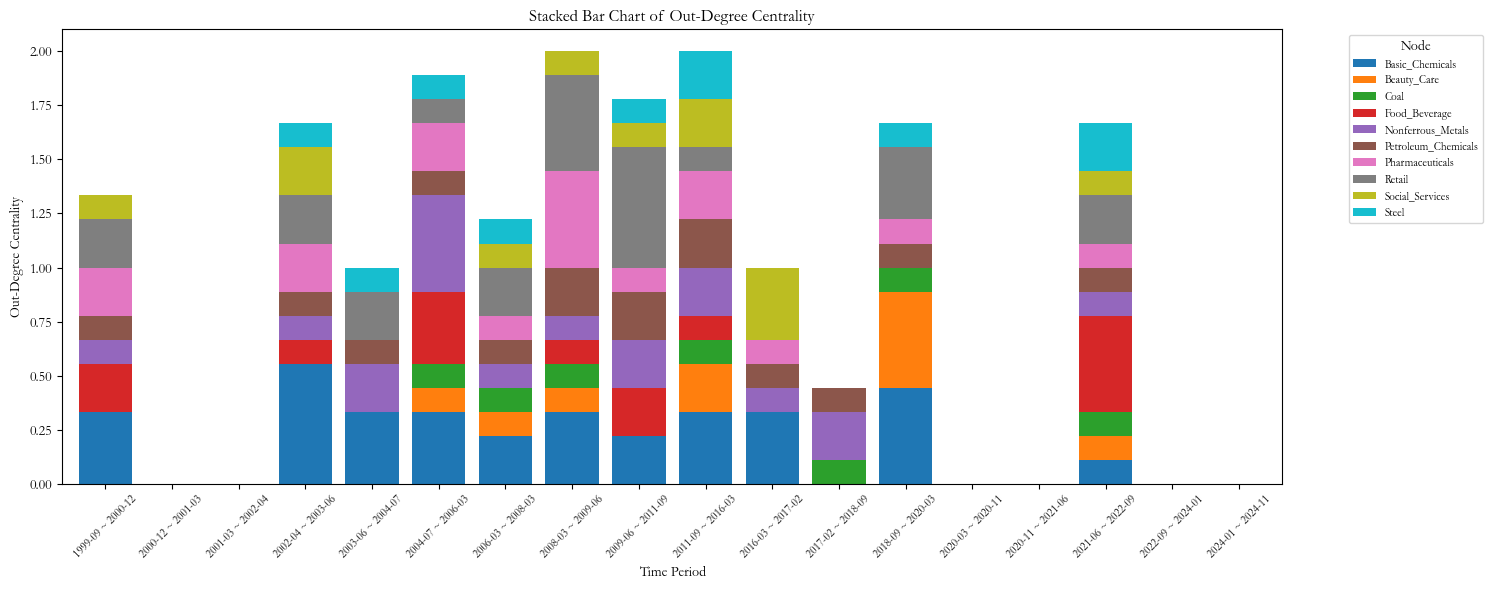

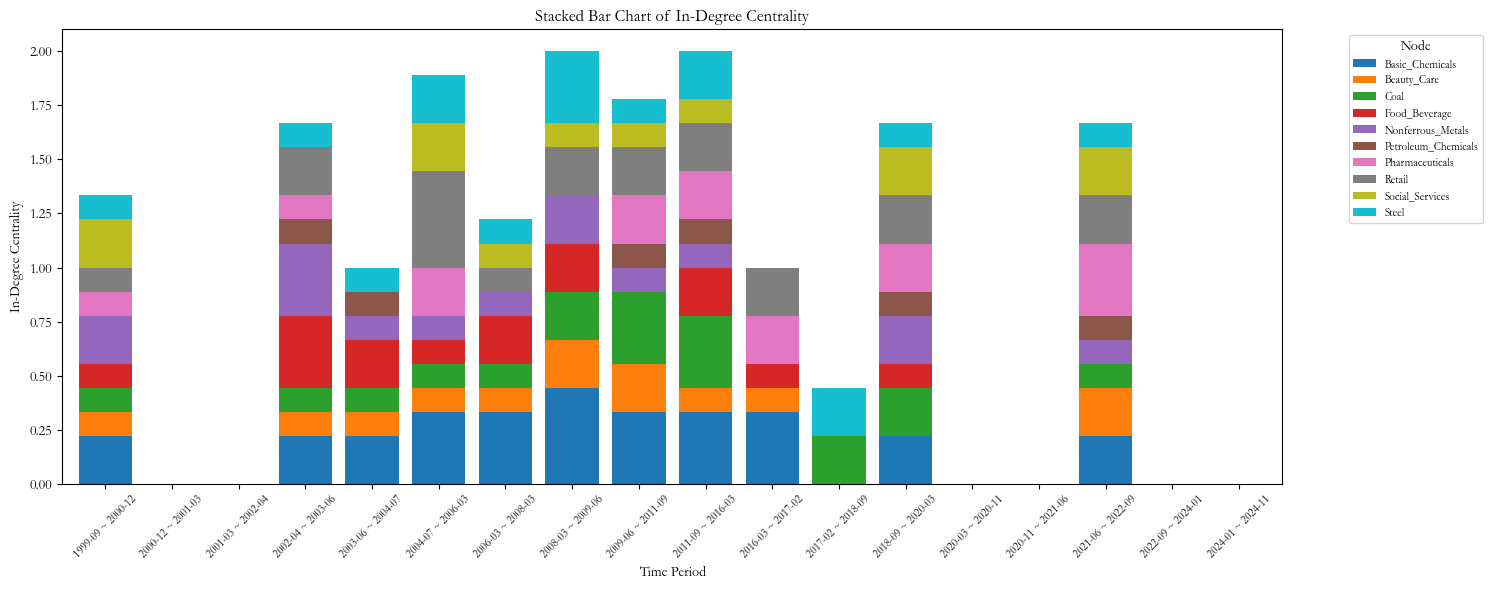

In [15]:
import pickle
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 加载存储的网络
with open('stored_networks.pkl', 'rb') as f:
    stored_networks = pickle.load(f)

# 初始化存储结果的 DataFrame
centrality_data = []

# Step 2: 遍历每个时间段网络，计算节点的出度中心性和入度中心性
for time_period, graph_nx in stored_networks.items():
    out_degree_centrality = nx.out_degree_centrality(graph_nx)
    in_degree_centrality = nx.in_degree_centrality(graph_nx)

    for node in graph_nx.nodes():
        centrality_data.append({
            "Time Period": time_period,
            "Node": node,
            "Out-Degree Centrality": out_degree_centrality.get(node, 0),
            "In-Degree Centrality": in_degree_centrality.get(node, 0),
        })

# 转换为 DataFrame
centrality_df = pd.DataFrame(centrality_data)

# 可视化出度和入度中心性随时间的变化
unique_nodes = centrality_df['Node'].unique()

# 创建堆积图的数据准备
stacked_out_degree = centrality_df.pivot(index="Time Period", columns="Node", values="Out-Degree Centrality").fillna(0)
stacked_in_degree = centrality_df.pivot(index="Time Period", columns="Node", values="In-Degree Centrality").fillna(0)

# 绘制出度中心性的堆积图
stacked_out_degree.plot(
    kind="bar",
    stacked=True,
    figsize=(15, 6),
    colormap="tab10",
    width=0.8
)
plt.xlabel("Time Period")
plt.ylabel("Out-Degree Centrality")
plt.title("Stacked Bar Chart of Out-Degree Centrality")
plt.xticks(rotation=45, fontsize=8)
plt.legend(title="Node", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# 绘制入度中心性的堆积图
stacked_in_degree.plot(
    kind="bar",
    stacked=True,
    figsize=(15, 6),
    colormap="tab10",
    width=0.8
)
plt.xlabel("Time Period")
plt.ylabel("In-Degree Centrality")
plt.title("Stacked Bar Chart of In-Degree Centrality")
plt.xticks(rotation=45, fontsize=8)
plt.legend(title="Node", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()




results without empty graph

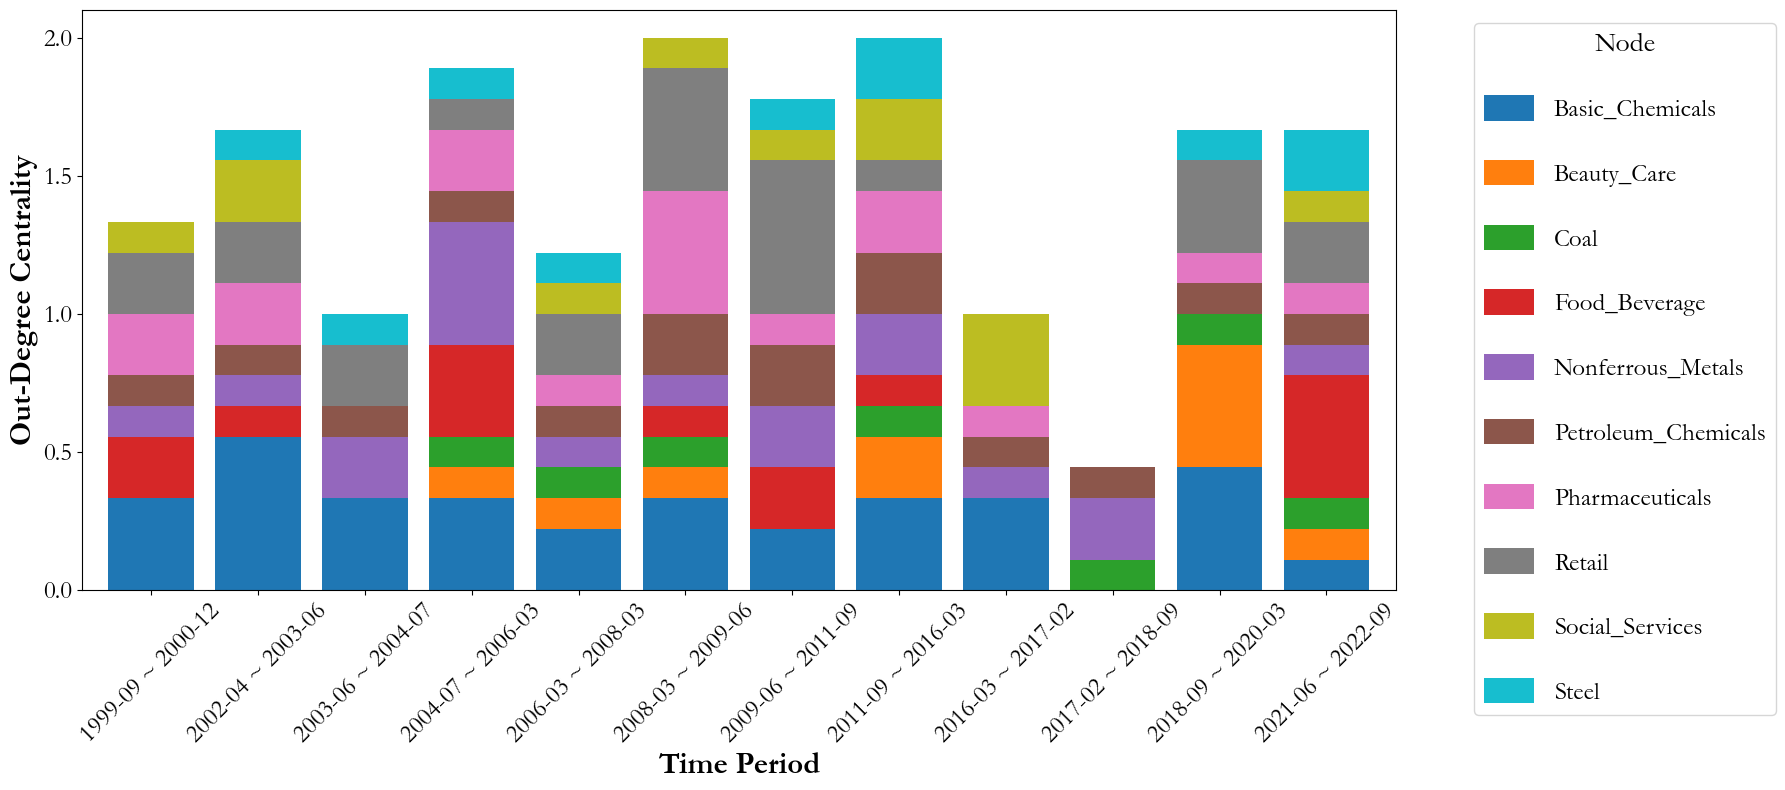

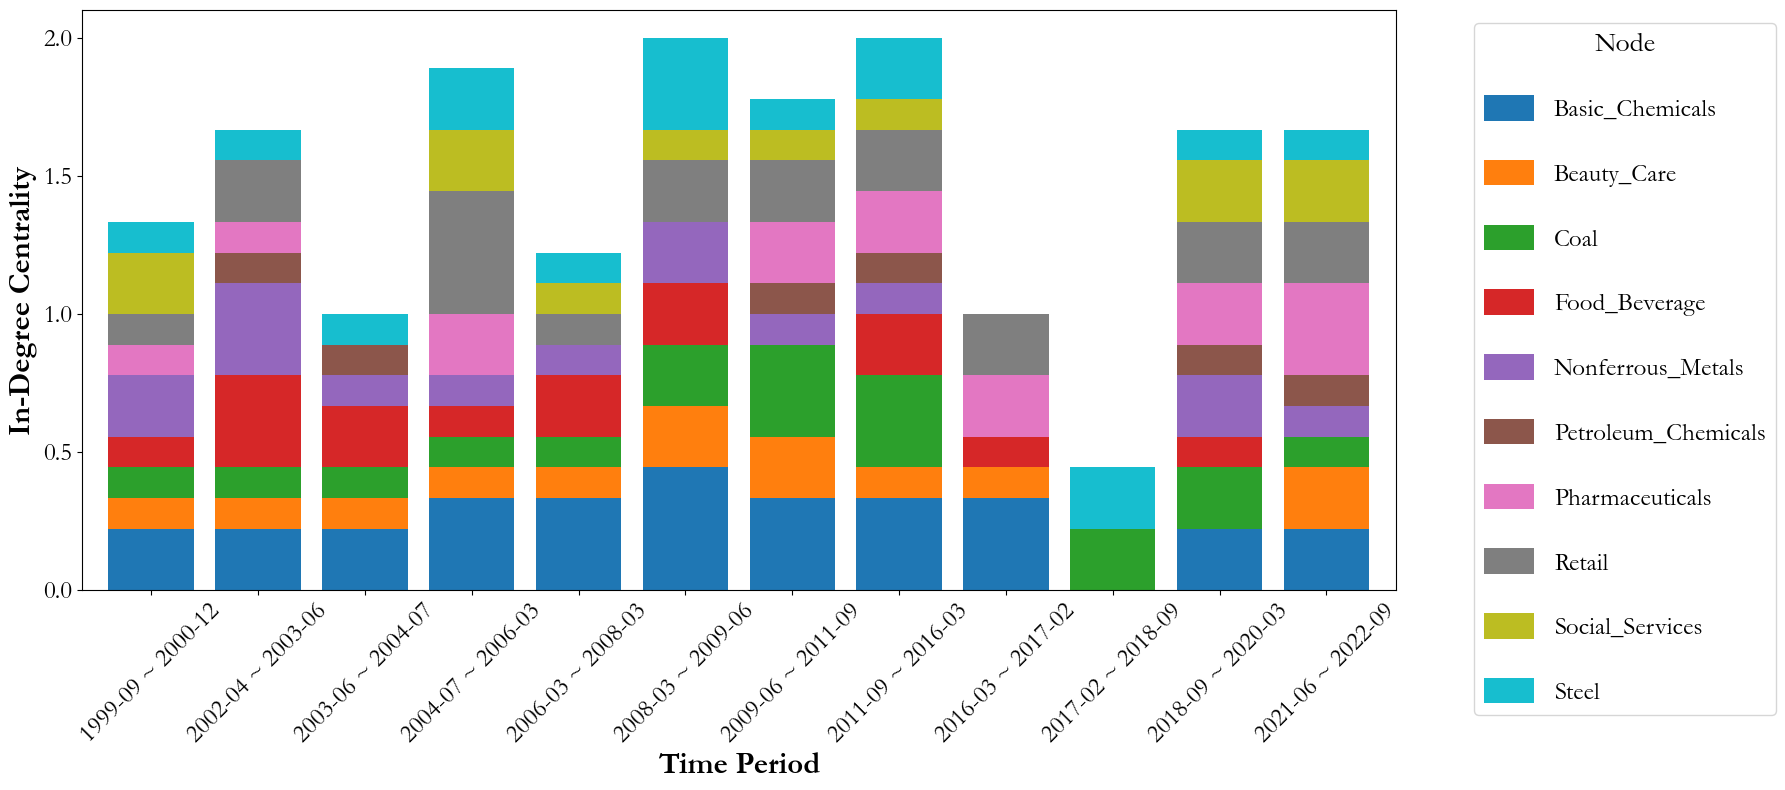

In [ ]:
# 过滤掉没有边的年份
valid_time_periods = centrality_df.groupby("Time Period").filter(
    lambda x: x["Out-Degree Centrality"].sum() > 0 or x["In-Degree Centrality"].sum() > 0
)["Time Period"].unique()

# 过滤 DataFrame 只保留有效年份
filtered_centrality_df = centrality_df[centrality_df["Time Period"].isin(valid_time_periods)]

# 创建堆积图的数据准备（不含空图）
stacked_out_degree_filtered = filtered_centrality_df.pivot(
    index="Time Period", columns="Node", values="Out-Degree Centrality"
).fillna(0)
stacked_in_degree_filtered = filtered_centrality_df.pivot(
    index="Time Period", columns="Node", values="In-Degree Centrality"
).fillna(0)


# 绘制出度中心性的堆积图（不含空图）
stacked_out_degree_filtered.plot(
    kind="bar",
    stacked=True,
    figsize=(18, 8),  # 增大图表尺寸
    colormap="tab10",
    width=0.8
)
plt.xlabel("Time Period", fontsize=22, fontweight='bold')  # 增大并加粗 x 轴标签字体
plt.ylabel("Out-Degree Centrality", fontsize=22, fontweight='bold')  # 增大并加粗 y 轴标签字体
# plt.title("Out-Degree Centrality", fontsize=24, fontweight='bold')  # 增大并加粗标题字体
plt.xticks(rotation=45, fontsize=18)  # 增大 x 轴刻度字体
plt.yticks(fontsize=18)  # 增大 y 轴刻度字体

# 设置图例字体属性
plt.legend(
    title="Node", 
    bbox_to_anchor=(1.05, 1), 
    loc="upper left", 
    fontsize=18,  # 图例字体放大
    title_fontsize=20,  # 图例标题字体放大
    labelspacing=1.5,  # 增加标签之间的间距
    handleheight=1.2  # 增加图例符号的高度
)

plt.tight_layout()

# 保存高清晰度的 PDF 图表，dpi 设置为 1200
plt.savefig("PCMCI_out_degree_centrality.pdf", dpi=1200, format='pdf')  # 保存为高清 PDF 文件
plt.show()

# 绘制入度中心性的堆积图（不含空图）
stacked_in_degree_filtered.plot(
    kind="bar",
    stacked=True,
    figsize=(18, 8),  # 增大图表尺寸
    colormap="tab10",
    width=0.8
)
plt.xlabel("Time Period", fontsize=22, fontweight='bold')  # 增大并加粗 x 轴标签字体
plt.ylabel("In-Degree Centrality", fontsize=22, fontweight='bold')  # 增大并加粗 y 轴标签字体
# plt.title("In-Degree Centrality", fontsize=24, fontweight='bold')  # 增大并加粗标题字体
plt.xticks(rotation=45, fontsize=18)  # 增大 x 轴刻度字体
plt.yticks(fontsize=18)  # 增大 y 轴刻度字体

# 设置图例字体属性
plt.legend(
    title="Node", 
    bbox_to_anchor=(1.05, 1), 
    loc="upper left", 
    fontsize=18,  # 图例字体放大
    title_fontsize=20,  # 图例标题字体放大
    labelspacing=1.5,  # 增加标签之间的间距
    handleheight=1.2  # 增加图例符号的高度
)

plt.tight_layout()

# 保存高清晰度的 PDF 图表，dpi 设置为 1200
plt.savefig("PCMCI_in_degree_centrality.pdf", dpi=1200, format='pdf')  # 保存为高清 PDF 文件
plt.show()



## Dominant Sectors 

Dominant Sectors for out degree centrality

In [19]:
import pandas as pd
import numpy as np


# 定义经济周期映射
cycle_mapping = {
    '1999-09 ~ 2000-12': 'Overheat',
    '2002-04 ~ 2003-06': 'Stagflation', 
    '2003-06 ~ 2004-07': 'Overheat',
    '2004-07 ~ 2006-03': 'Reflation',
    '2006-03 ~ 2008-03': 'Overheat',
    '2008-03 ~ 2009-06': 'Reflation',
    '2009-06 ~ 2011-09': 'Overheat',
    '2011-09 ~ 2016-03': 'Reflation',
    '2016-03 ~ 2017-02': 'Recovery',
    '2017-02 ~ 2018-09': 'Overheat',
    '2018-09 ~ 2020-03': 'Stagflation',
    '2021-06 ~ 2022-09': 'Stagflation'
}

# 将经济周期映射添加到数据框（基于索引）
stacked_out_degree_filtered_copy = stacked_out_degree_filtered.copy()
stacked_out_degree_filtered_copy['Economic_Cycle'] = stacked_out_degree_filtered_copy.index.map(cycle_mapping)

# 获取所有行业列（除了Economic_Cycle）
industry_columns = [col for col in stacked_out_degree_filtered_copy.columns if col != 'Economic_Cycle']

# 按经济周期分组并计算平均值
out_degree_cycle_averages = stacked_out_degree_filtered_copy.groupby('Economic_Cycle')[industry_columns].mean()

# 重新排序行（按经济周期的逻辑顺序）
cycle_order = ['Recovery', 'Overheat', 'Stagflation', 'Reflation']
out_degree_cycle_averages = out_degree_cycle_averages.reindex([cycle for cycle in cycle_order if cycle in out_degree_cycle_averages.index])

# 显示结果
print("各行业在不同经济周期下的out_degree平均值:")
print("=" * 80)
print(out_degree_cycle_averages.round(6))

# 创建一个更易读的表格
print("\n" + "=" * 80)
print("详细结果表格 (Out-Degree):")
print("=" * 80)

# 转置表格以便更好地查看
out_degree_cycle_averages_transposed = out_degree_cycle_averages.T
print(out_degree_cycle_averages_transposed.round(2))

# 计算一些统计信息
print("\n" + "=" * 80)
print("Out-Degree统计摘要:")
print("=" * 80)

for cycle in out_degree_cycle_averages.index:
    print(f"\n{cycle} 周期:")
    values = out_degree_cycle_averages.loc[cycle]
    print(f"  - 最高值行业: {values.idxmax()} ({values.max():.2f})")
    print(f"  - 最低值行业: {values.idxmin()} ({values.min():.2f})")
    print(f"  - 平均值: {values.mean():.2f}")

# 找出每个行业在哪个经济周期中表现最佳
print(f"\n{'='*80}")
print("各行业Out-Degree最佳表现周期:")
print("=" * 80)

for industry in industry_columns:
    best_cycle = out_degree_cycle_averages[industry].idxmax()
    best_value = out_degree_cycle_averages[industry].max()
    print(f"{industry}: {best_cycle} ({best_value:.6f})")

# 额外分析：比较不同周期的行业活跃度
print(f"\n{'='*80}")
print("经济周期比较分析 (Out-Degree):")
print("=" * 80)

cycle_stats = pd.DataFrame({
    'Average_Out_Degree': out_degree_cycle_averages.mean(axis=1),
    'Max_Out_Degree': out_degree_cycle_averages.max(axis=1),
    'Min_Out_Degree': out_degree_cycle_averages.min(axis=1),
    'Std_Out_Degree': out_degree_cycle_averages.std(axis=1)
})

print("各经济周期的总体统计:")
print(cycle_stats.round(2))

# 识别最活跃的行业（平均out_degree最高）
print(f"\n{'='*80}")
print("行业活跃度排名 (基于平均Out-Degree):")
print("=" * 80)

industry_overall_avg = out_degree_cycle_averages.mean()
industry_ranking = industry_overall_avg.sort_values(ascending=False)

for i, (industry, avg_value) in enumerate(industry_ranking.items(), 1):
    print(f"{i:2d}. {industry}: {avg_value:.6f}")

各行业在不同经济周期下的out_degree平均值:
Node            Basic_Chemicals  Beauty_Care      Coal  Food_Beverage  \
Economic_Cycle                                                          
Recovery               0.333333     0.000000  0.000000       0.000000   
Overheat               0.222222     0.022222  0.044444       0.088889   
Stagflation            0.370370     0.185185  0.074074       0.185185   
Reflation              0.333333     0.148148  0.111111       0.185185   

Node            Nonferrous_Metals  Petroleum_Chemicals  Pharmaceuticals  \
Economic_Cycle                                                            
Recovery                 0.111111             0.111111         0.111111   
Overheat                 0.177778             0.133333         0.088889   
Stagflation              0.074074             0.111111         0.148148   
Reflation                0.259259             0.185185         0.296296   

Node              Retail  Social_Services     Steel  
Economic_Cycle               

Dominant Sectors for in degree centrality

In [20]:
import pandas as pd
import numpy as np


# 定义经济周期映射,这里仅定义不含空图的
cycle_mapping = {
    '1999-09 ~ 2000-12': 'Overheat',
    '2002-04 ~ 2003-06': 'Stagflation', 
    '2003-06 ~ 2004-07': 'Overheat',
    '2004-07 ~ 2006-03': 'Reflation',
    '2006-03 ~ 2008-03': 'Overheat',
    '2008-03 ~ 2009-06': 'Reflation',
    '2009-06 ~ 2011-09': 'Overheat',
    '2011-09 ~ 2016-03': 'Reflation',
    '2016-03 ~ 2017-02': 'Recovery',
    '2017-02 ~ 2018-09': 'Overheat',
    '2018-09 ~ 2020-03': 'Stagflation',
    '2021-06 ~ 2022-09': 'Stagflation'
}

# 将经济周期映射添加到数据框（基于索引）
stacked_in_degree_filtered['Economic_Cycle'] = stacked_in_degree_filtered.index.map(cycle_mapping)

# 获取所有行业列（除了Economic_Cycle）
industry_columns = [col for col in stacked_in_degree_filtered.columns if col != 'Economic_Cycle']

# 按经济周期分组并计算平均值
cycle_averages = stacked_in_degree_filtered.groupby('Economic_Cycle')[industry_columns].mean()

# 重新排序行（按经济周期的逻辑顺序）
cycle_order = ['Recovery', 'Overheat', 'Stagflation', 'Reflation']
cycle_averages = cycle_averages.reindex([cycle for cycle in cycle_order if cycle in cycle_averages.index])

# 显示结果
print("各行业在不同经济周期下的in_degree平均值:")
print("=" * 80)
print(cycle_averages.round(6))

# 创建一个更易读的表格
print("\n" + "=" * 80)
print("详细结果表格:")
print("=" * 80)

# 转置表格以便更好地查看
cycle_averages_transposed = cycle_averages.T
print(cycle_averages_transposed.round(2))

# 计算一些统计信息
print("\n" + "=" * 80)
print("统计摘要:")
print("=" * 80)

for cycle in cycle_averages.index:
    print(f"\n{cycle} 周期:")
    values = cycle_averages.loc[cycle]
    print(f"  - 最高值行业: {values.idxmax()} ({values.max():.2f})")
    print(f"  - 最低值行业: {values.idxmin()} ({values.min():.2f})")
    print(f"  - 平均值: {values.mean():.2f}")

# 找出每个行业在哪个经济周期中表现最佳
print(f"\n{'='*80}")
print("各行业最佳表现周期:")
print("=" * 80)

for industry in industry_columns:
    best_cycle = cycle_averages[industry].idxmax()
    best_value = cycle_averages[industry].max()
    print(f"{industry}: {best_cycle} ({best_value:.2f})")

各行业在不同经济周期下的in_degree平均值:
Node            Basic_Chemicals  Beauty_Care      Coal  Food_Beverage  \
Economic_Cycle                                                          
Recovery               0.333333     0.111111  0.000000       0.111111   
Overheat               0.222222     0.111111  0.177778       0.111111   
Stagflation            0.222222     0.111111  0.148148       0.148148   
Reflation              0.370370     0.148148  0.222222       0.185185   

Node            Nonferrous_Metals  Petroleum_Chemicals  Pharmaceuticals  \
Economic_Cycle                                                            
Recovery                 0.000000             0.000000         0.222222   
Overheat                 0.111111             0.044444         0.066667   
Stagflation              0.222222             0.111111         0.222222   
Reflation                0.148148             0.037037         0.148148   

Node              Retail  Social_Services     Steel  
Economic_Cycle                

## 2.2 Density & ACC

results include empty graph

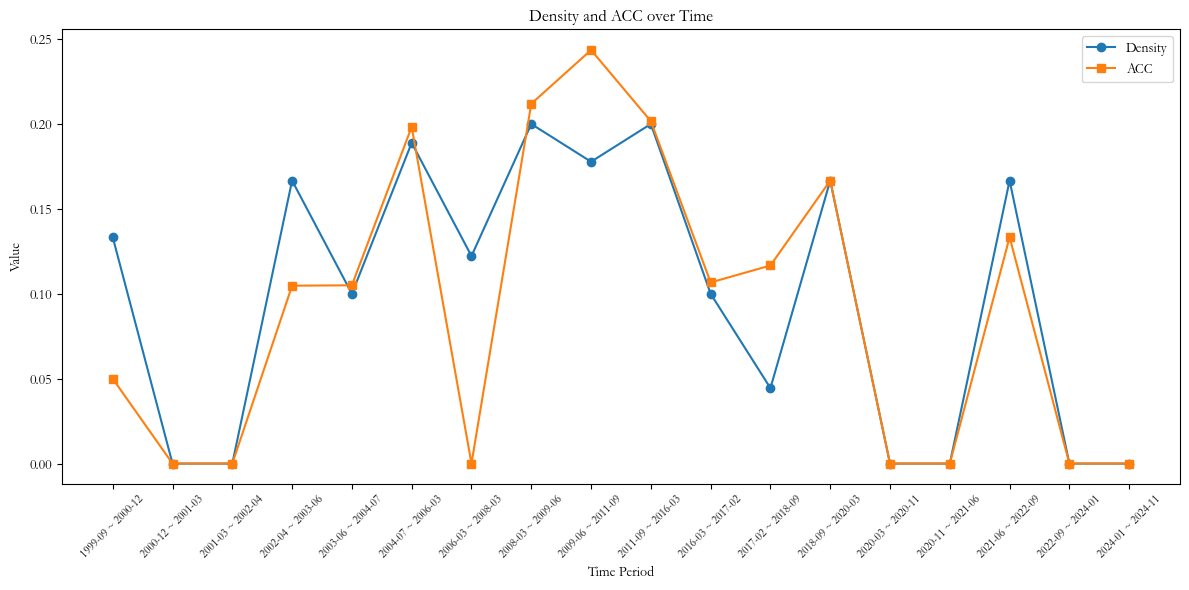

In [21]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: 加载存储的网络
with open('stored_networks.pkl', 'rb') as f:
    stored_networks = pickle.load(f)

# 初始化一个列表，用于存储每个网络的拓扑分析结果
network_analysis = []

# Step 2: 遍历存储的每个时间段网络，分析 ACC 和 Density
for time_period, graph_nx in stored_networks.items():
    # 检查是否为空图
    if graph_nx.number_of_nodes() == 0 or graph_nx.number_of_edges() == 0:
        # 对空图的指标设为零
        network_analysis.append({
            "Time Period": time_period,
            "Density": 0,
            "ACC": 0
        })
        continue

    # 网络密度
    density = nx.density(graph_nx)
    
    # 平均聚类系数 (ACC)
    acc = nx.average_clustering(graph_nx)
    
    # 汇总网络整体统计
    network_analysis.append({
        "Time Period": time_period,
        "Density": density,
        "ACC": acc
    })

# 将网络整体统计结果转化为 DataFrame
network_summary_df = pd.DataFrame(network_analysis)

# 按时间排序
network_summary_df = network_summary_df.sort_values(by="Time Period")

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(network_summary_df["Time Period"], network_summary_df["Density"], label="Density", marker="o")
plt.plot(network_summary_df["Time Period"], network_summary_df["ACC"], label="ACC", marker="s")
plt.xlabel("Time Period")
plt.ylabel("Value")
plt.title("Density and ACC over Time")
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()



# 显示图表
plt.show()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Network ACC and Density Summary", dataframe=network_summary_df)


results without empty graph

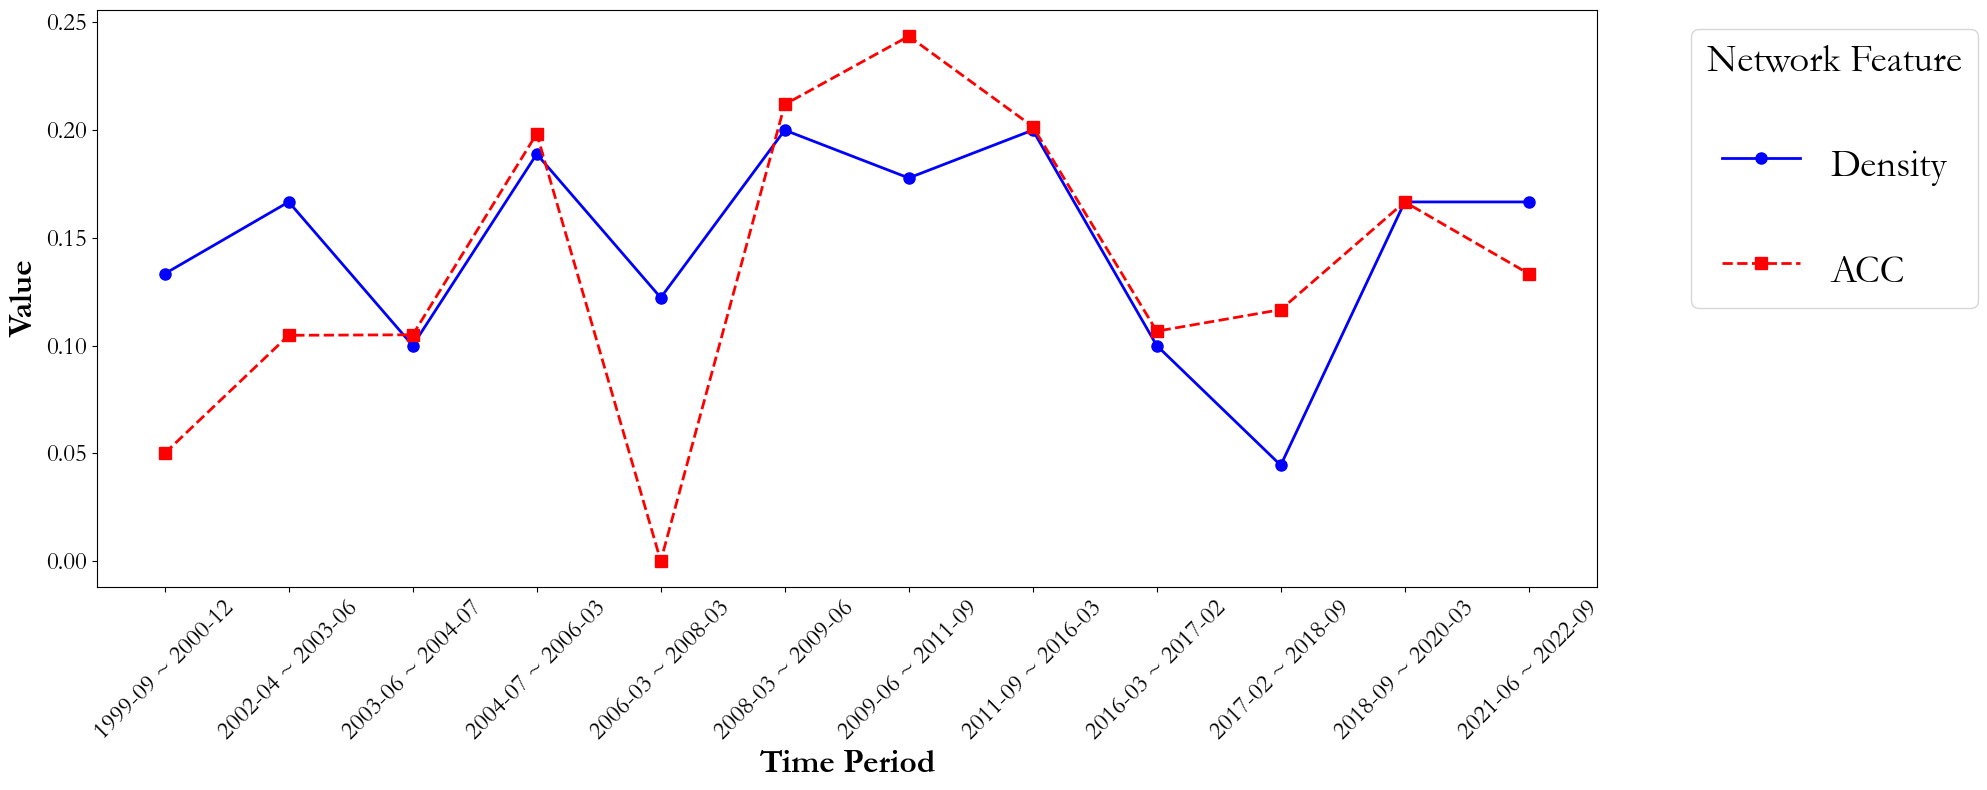

In [ ]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: 加载存储的网络
with open('stored_networks.pkl', 'rb') as f:
    stored_networks = pickle.load(f)

# 初始化一个列表，用于存储每个网络的拓扑分析结果
network_analysis = []

# Step 2: 遍历存储的每个时间段网络，分析 ACC 和 Density
for time_period, graph_nx in stored_networks.items():
    # 检查是否为空图
    if graph_nx.number_of_nodes() == 0 or graph_nx.number_of_edges() == 0:
        continue  # 跳过空图

    # 网络密度
    density = nx.density(graph_nx)
    
    # 平均聚类系数 (ACC)
    acc = nx.average_clustering(graph_nx)
    
    # 汇总网络整体统计
    network_analysis.append({
        "Time Period": time_period,
        "Density": density,
        "ACC": acc
    })

# 将网络整体统计结果转化为 DataFrame
network_summary_df = pd.DataFrame(network_analysis)

# 按时间排序
network_summary_df = network_summary_df.sort_values(by="Time Period")

# 可视化
plt.figure(figsize=(20, 8))  # 增大图表尺寸
plt.plot(network_summary_df["Time Period"], network_summary_df["Density"], label="Density", marker="o", linestyle='-', color='b', markersize=8, linewidth=2)
plt.plot(network_summary_df["Time Period"], network_summary_df["ACC"], label="ACC", marker="s", linestyle='--', color='r', markersize=8, linewidth=2)

# 设置坐标轴标签
plt.xlabel("Time Period", fontsize=24, fontweight='bold')  # 加大并加粗 x 轴标签字体
plt.ylabel("Value", fontsize=24, fontweight='bold')  # 加大并加粗 y 轴标签字体

# 设置标题
# plt.title("Density and ACC over Time", fontsize=28, fontweight='bold')  # 加大并加粗标题字体

# 设置 x 轴刻度字体
plt.xticks(rotation=45, fontsize=18)  # 增大并旋转 x 轴刻度字体
plt.yticks(fontsize=18)  # 增大 y 轴刻度字体

# 设置图例
plt.legend(
    title="Network Feature", 
    title_fontsize=28,  # 图例标题字体放大
    bbox_to_anchor=(1.05, 1),  # 调整图例位置
    loc="upper left", 
    fontsize=28,  # 图例字体放大
    labelspacing=1.5,  # 增加标签之间的间距
    handleheight=1.5  # 增加图例符号的高度
)

# 调整布局，使图表不重叠
plt.tight_layout()

# 保存高清晰度的图表
# plt.savefig("network_feature.png", dpi=300)  # 保证高清晰度保存
plt.savefig("PCMCI_network_feature.pdf", dpi=1200, format='pdf')  # 保存为高清 PDF 文件

# 显示图表
plt.show()



# 3 non-segement based results

In [24]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pickle

# 定义显著行业列表
selected_industries = [
    'Food_Beverage', 'Steel', 'Beauty_Care', 'Nonferrous_Metals',
    'Basic_Chemicals', 'Pharmaceuticals', 'Retail', 'Coal',
    'Social_Services', 'Petroleum_Chemicals'
]

# 加载对数收益率数据
log_returns = pd.read_excel('log_returns.xlsx')  # 替换为你的数据路径
log_returns['Date'] = pd.to_datetime(log_returns['Date'])
log_returns = log_returns.set_index('Date')

# 筛选指定行业
df = log_returns[selected_industries].reset_index()

# 转换为 Tigramite 的 DataFrame 格式
data = df.set_index('Date')[selected_industries]
dataframe = pp.DataFrame(
    data.values,
    datatime={0: np.arange(len(data))},
    var_names=data.columns
)

# 初始化 PCMCI+ 分析
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)

# 运行 PCMCI+，可调整 tau_min 和 tau_max 以捕获不同时间滞后的因果关系
results = pcmci.run_pcmciplus(tau_min=0, tau_max=0, pc_alpha=None)

# 转换为 NetworkX 图
graph_nx = nx.DiGraph()

# 确保所有节点被添加到图中
for industry in selected_industries:
    graph_nx.add_node(industry)

# 根据 PCMCI+ 结果添加边
var_names = data.columns
for j, row in enumerate(results['graph']):
    for k, value in enumerate(row):
        if '-->' in value:  # j influences k
            graph_nx.add_edge(var_names[j], var_names[k])
        elif '<--' in value:  # k influences j
            graph_nx.add_edge(var_names[k], var_names[j])

# # 显示图形
# plt.figure(figsize=(10, 8))
# nx.draw(graph_nx, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
# plt.show()

# 如果需要保存图形到文件，可以取消下面的注释：
with open('non-segment.pkl', 'wb') as f:
    pickle.dump(graph_nx, f)

print(f"Generated and displayed a single NetworkX graph for analysis.")


Generated and displayed a single NetworkX graph for analysis.


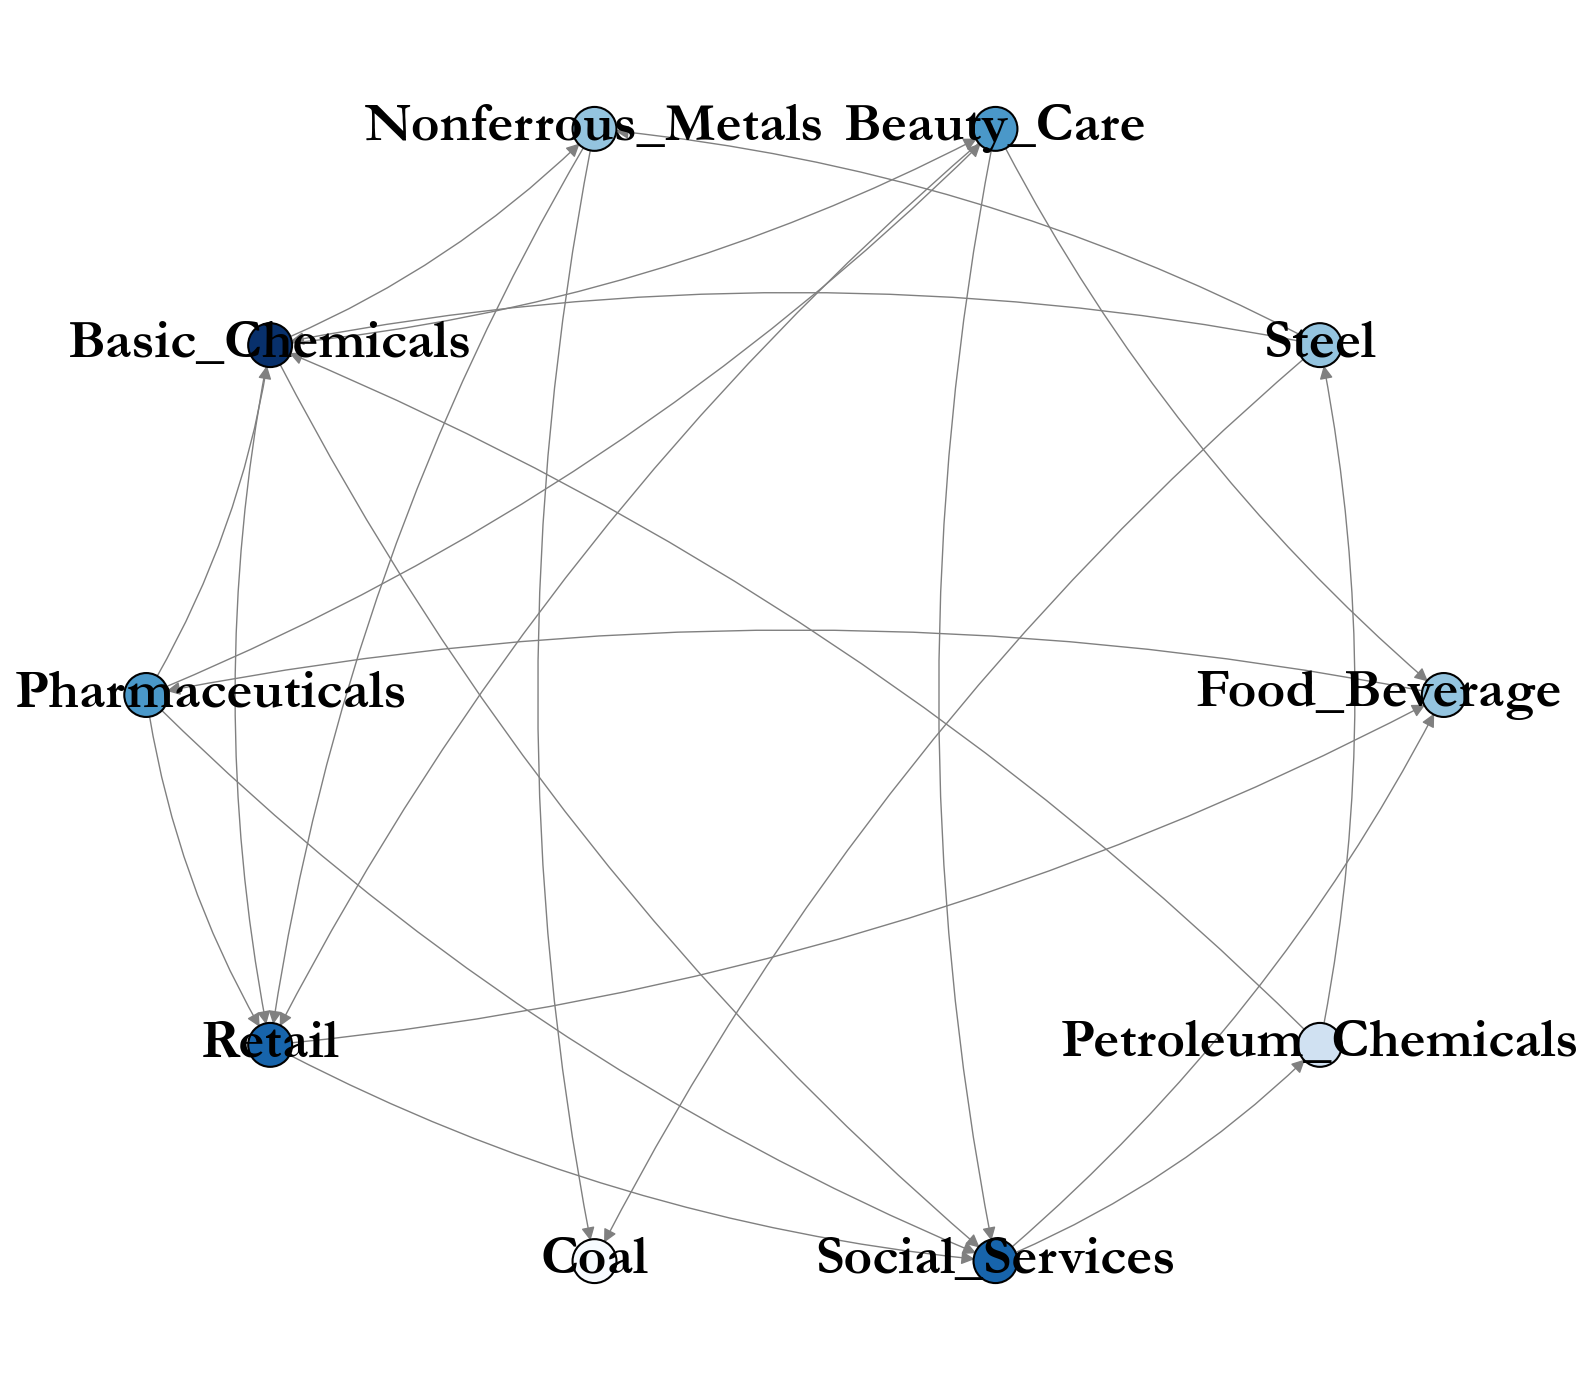

In [25]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体为 Garamond
rcParams['font.family'] = 'Garamond'

# Step 1: 加载存储的网络
with open('non-segment.pkl', 'rb') as f:
    graph_nx = pickle.load(f)

# 使用圆形布局计算节点位置
pos = nx.circular_layout(graph_nx)

# 设置图形大小
plt.figure(figsize=(16,14))

# 绘制网络节点
node_color = [graph_nx.degree(node) for node in graph_nx.nodes()]
nx.draw_networkx_nodes(
    graph_nx, pos,
    node_size=1000, node_color=node_color,
    cmap=plt.cm.Blues, edgecolors='black', linewidths=1.5
)

# 绘制网络边
nx.draw_networkx_edges(
    graph_nx, pos,
    edge_color='gray', arrows=True,
    arrowstyle='-|>', arrowsize=20,
    connectionstyle="arc3,rad=0.1",
    min_source_margin=15, min_target_margin=15
)

# 绘制所有节点标签
labels = {node: node for node in graph_nx.nodes()}
label_objects = nx.draw_networkx_labels(
    graph_nx, pos, labels,
    font_size=40, font_color='black',
    font_family='Garamond', font_weight='bold'
)

# ==== 手动调节某个节点标签位置 ====
special_node = "Pharmaceuticals"
if special_node in label_objects:
    x, y = label_objects[special_node].get_position()
    label_objects[special_node].set_position((x + 0.1, y))  # 偏移量

# ==== 手动调节某个节点标签位置 ====
special_node = "Food_Beverage"
if special_node in label_objects:
    x, y = label_objects[special_node].get_position()
    label_objects[special_node].set_position((x - 0.1, y))  # 偏移量

# 关闭坐标轴
plt.axis('off')
plt.tight_layout()

# 保存为高清PDF
plt.savefig("non-segment.pdf", dpi=1200, bbox_inches='tight', format='pdf')

# 显示图像
plt.show()


# 3 Comparison study

In [26]:
import networkx as nx

# 计算出度与入度中心性
def calculate_centrality(graph_nx):
    out_degree_centrality = nx.out_degree_centrality(graph_nx)
    in_degree_centrality = nx.in_degree_centrality(graph_nx)
    return out_degree_centrality, in_degree_centrality

# 计算网络密度
def calculate_density(graph_nx):
    return nx.density(graph_nx)

# 计算平均聚类系数
def calculate_avg_clustering(graph_nx):
    return nx.average_clustering(graph_nx)

# 计算ACC
def calculate_acc(pred_edges, true_edges):
    intersection = pred_edges.intersection(true_edges)
    return len(intersection) / len(true_edges) if true_edges else 0

# 真实边集示例 (如果有的话)
true_edges = {('node1', 'node2'), ('node3', 'node4')}  # 示例

# 对没有经济周期切分的网络计算
out_degree_centrality, in_degree_centrality = calculate_centrality(graph_nx)
density_non_segmented = calculate_density(graph_nx)
avg_clustering_non_segmented = calculate_avg_clustering(graph_nx)
acc_non_segmented = calculate_acc(set(graph_nx.edges()), true_edges)

# 输出结果
print(f"Out-degree centrality (non-segmented network):", list(out_degree_centrality.items())[:5])
print(f"In-degree centrality (non-segmented network):", list(in_degree_centrality.items())[:5])
print(f"Density (non-segmented network): {density_non_segmented}")
print(f"Average Clustering Coefficient (non-segmented network): {avg_clustering_non_segmented}")
print(f"ACC (non-segmented network): {acc_non_segmented}")

# 对经济周期切分后的网络计算
for time_period, graph_nx in stored_networks.items():
    out_degree_centrality, in_degree_centrality = calculate_centrality(graph_nx)
    density_segmented = calculate_density(graph_nx)
    avg_clustering_segmented = calculate_avg_clustering(graph_nx)
    acc_segmented = calculate_acc(set(graph_nx.edges()), true_edges)
    
    print(f"Out-degree centrality ({time_period}):", list(out_degree_centrality.items())[:5])
    print(f"In-degree centrality ({time_period}):", list(in_degree_centrality.items())[:5])
    print(f"Density ({time_period}): {density_segmented}")
    print(f"Average Clustering Coefficient ({time_period}): {avg_clustering_segmented}")
    print(f"ACC ({time_period}): {acc_segmented}")


Out-degree centrality (non-segmented network): [('Food_Beverage', 0.1111111111111111), ('Steel', 0.3333333333333333), ('Beauty_Care', 0.3333333333333333), ('Nonferrous_Metals', 0.2222222222222222), ('Basic_Chemicals', 0.4444444444444444)]
In-degree centrality (non-segmented network): [('Food_Beverage', 0.3333333333333333), ('Steel', 0.1111111111111111), ('Beauty_Care', 0.2222222222222222), ('Nonferrous_Metals', 0.2222222222222222), ('Basic_Chemicals', 0.3333333333333333)]
Density (non-segmented network): 0.25555555555555554
Average Clustering Coefficient (non-segmented network): 0.36380952380952386
ACC (non-segmented network): 0.0
Out-degree centrality (1999-09 ~ 2000-12): [('Food_Beverage', 0.2222222222222222), ('Steel', 0.0), ('Beauty_Care', 0.0), ('Nonferrous_Metals', 0.1111111111111111), ('Basic_Chemicals', 0.3333333333333333)]
In-degree centrality (1999-09 ~ 2000-12): [('Food_Beverage', 0.1111111111111111), ('Steel', 0.1111111111111111), ('Beauty_Care', 0.1111111111111111), ('Nonf

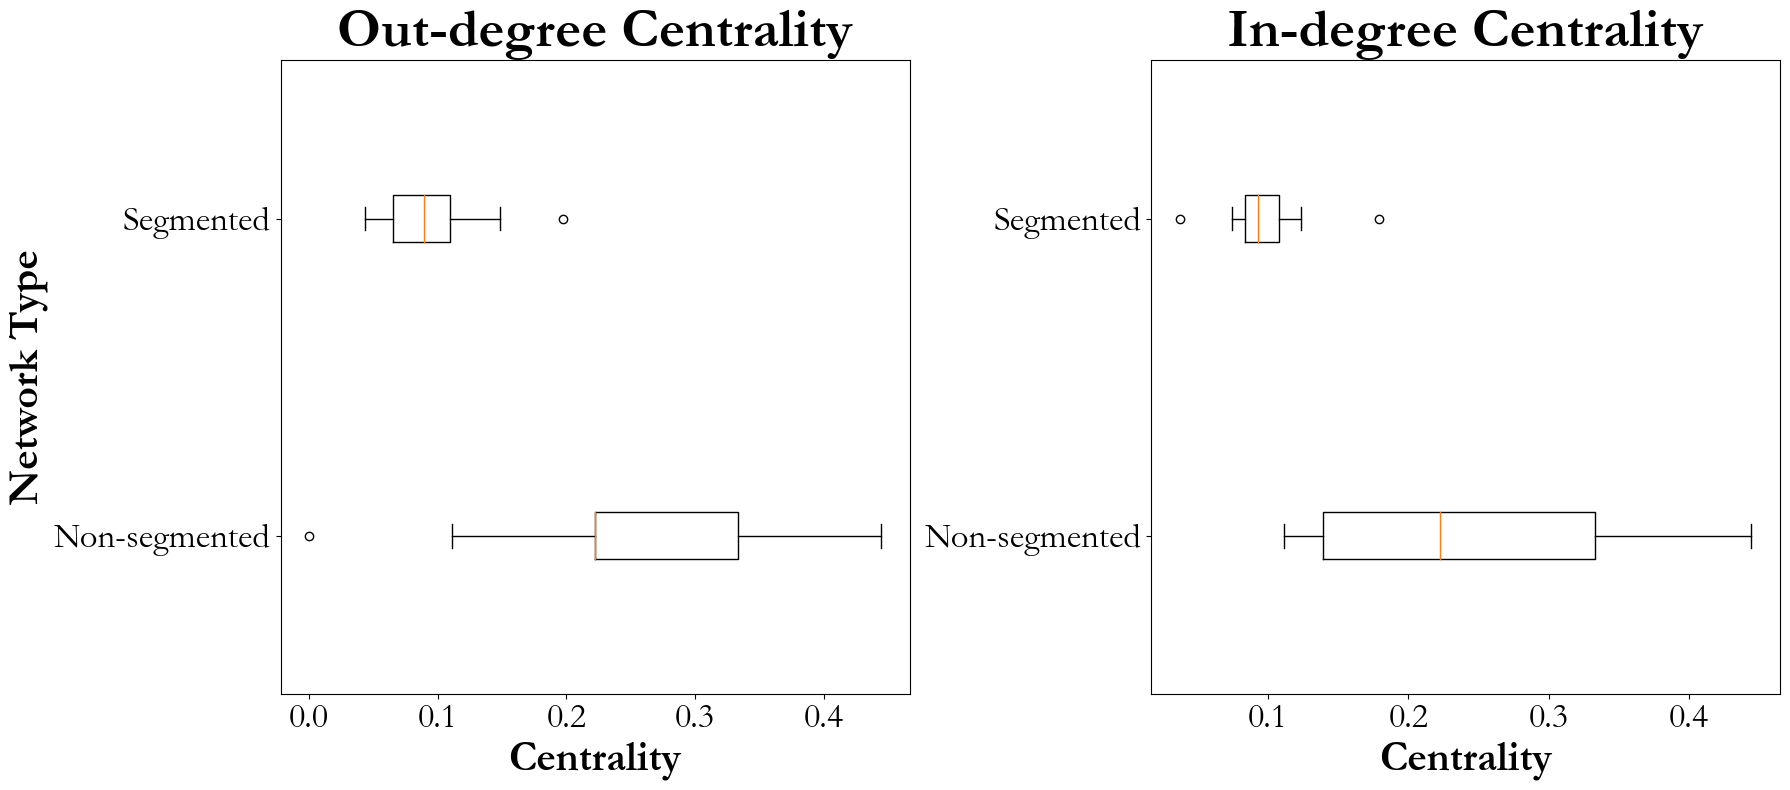

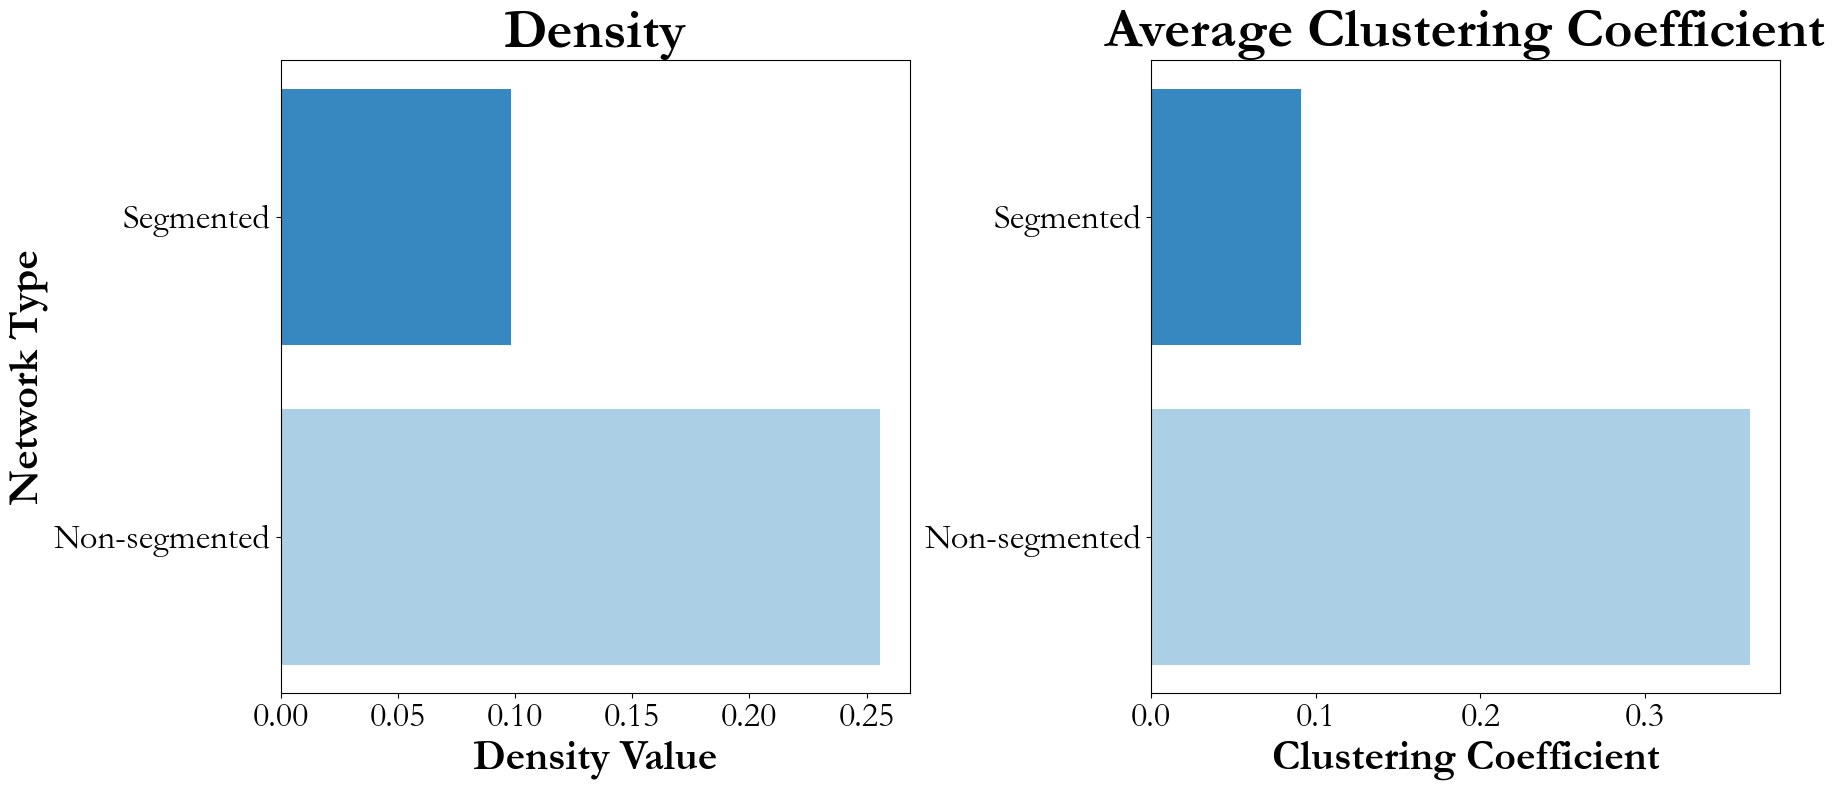

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib import rcParams

# 设置全局字体为 Garamond
rcParams['font.family'] = 'Garamond'
rcParams['axes.labelweight'] = 'bold'  # 设置标签加粗
rcParams['axes.titlesize'] = 20  # 设置标题字体大小
rcParams['axes.labelsize'] = 30  # 设置标签字体大小
rcParams['xtick.labelsize'] = 25  # 设置x轴刻度标签字体大小
rcParams['ytick.labelsize'] = 25  # 设置y轴刻度标签字体大小

# 计算出度中心性、入度中心性、密度、聚类系数
def calculate_centrality(graph):
    out_degree_centrality = nx.out_degree_centrality(graph)
    in_degree_centrality = nx.in_degree_centrality(graph)
    return out_degree_centrality, in_degree_centrality

def calculate_density(graph):
    return nx.density(graph)

def calculate_avg_clustering(graph):
    return nx.average_clustering(graph)

# 导入没有切分的网络
with open('non-segment.pkl', 'rb') as f:
    non_segmented_network = pickle.load(f)

# 导入有切分的网络
with open('stored_networks.pkl', 'rb') as f:
    segmented_networks = pickle.load(f)

# 存储指标的字典
metrics = {
    "Out-degree centrality": [],
    "In-degree centrality": [],
    "Density": [],
    "Average Clustering Coefficient": []
}

# 对没有切分的网络计算
out_degree_centrality, in_degree_centrality = calculate_centrality(non_segmented_network)
density_non_segmented = calculate_density(non_segmented_network)
avg_clustering_non_segmented = calculate_avg_clustering(non_segmented_network)

# 将没有切分的网络结果存入metrics
metrics["Out-degree centrality"].append(('Non-segmented', list(out_degree_centrality.values())))
metrics["In-degree centrality"].append(('Non-segmented', list(in_degree_centrality.values())))
metrics["Density"].append(('Non-segmented', density_non_segmented))
metrics["Average Clustering Coefficient"].append(('Non-segmented', avg_clustering_non_segmented))

# 对有切分的网络计算并排除空图
out_degree_cent_all = []
in_degree_cent_all = []
density_all = []
avg_clustering_all = []

for time_period, graph_nx in segmented_networks.items():
    if len(graph_nx.nodes()) == 0:  # 排除空图
        continue
    
    # 计算各项指标
    out_degree_centrality, in_degree_centrality = calculate_centrality(graph_nx)
    density_segmented = calculate_density(graph_nx)
    avg_clustering_segmented = calculate_avg_clustering(graph_nx)
    
    # 将每个时间段的指标保存到对应列表
    out_degree_cent_all.append(list(out_degree_centrality.values()))
    in_degree_cent_all.append(list(in_degree_centrality.values()))
    density_all.append(density_segmented)
    avg_clustering_all.append(avg_clustering_segmented)

# 计算切分网络的平均值
metrics["Out-degree centrality"].append(('Segmented', [sum(val) / len(val) for val in zip(*out_degree_cent_all)]))
metrics["In-degree centrality"].append(('Segmented', [sum(val) / len(val) for val in zip(*in_degree_cent_all)]))
metrics["Density"].append(('Segmented', sum(density_all) / len(density_all)))
metrics["Average Clustering Coefficient"].append(('Segmented', sum(avg_clustering_all) / len(avg_clustering_all)))

# 1. 绘制出度中心性和入度中心性的对比图
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 绘制出度中心性的对比
out_degree_data = metrics["Out-degree centrality"]
time_periods_out = [entry[0] for entry in out_degree_data]
values_out = [entry[1] for entry in out_degree_data]

axes[0].boxplot(values_out, vert=False)
axes[0].set_yticklabels(time_periods_out)
axes[0].set_title('Out-degree Centrality', fontsize=40, fontweight='bold')  # 更大字体
axes[0].set_xlabel('Centrality', fontsize=30, fontweight='bold')  # 更大字体
axes[0].set_ylabel('Network Type', fontsize=30, fontweight='bold')  # 更大字体
axes[0].grid(axis='x', visible=False)  # 去掉竖线网格，保留横线网格

# 绘制入度中心性的对比
in_degree_data = metrics["In-degree centrality"]
time_periods_in = [entry[0] for entry in in_degree_data]
values_in = [entry[1] for entry in in_degree_data]

axes[1].boxplot(values_in, vert=False)
axes[1].set_yticklabels(time_periods_in)
axes[1].set_title('In-degree Centrality', fontsize=40, fontweight='bold')  # 更大字体
axes[1].set_xlabel('Centrality', fontsize=30, fontweight='bold')  # 更大字体
# axes[1].set_ylabel('Network Type', fontsize=30, fontweight='bold')  # 更大字体
axes[1].grid(axis='x', visible=False)  # 去掉竖线网格，保留横线网格

# 自动调整布局
plt.tight_layout()

# 保存为高清PDF
plt.savefig('degree_centrality_comparison.pdf', dpi=1200, bbox_inches='tight', format='pdf')

# 显示图表
plt.show()

# 2. 绘制密度和聚类系数（ACC）的对比图
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 绘制密度的对比
density_data = metrics["Density"]
time_periods_density = [entry[0] for entry in density_data]
values_density = [entry[1] for entry in density_data]

axes[0].barh(time_periods_density, values_density, color=sns.color_palette("Blues", len(time_periods_density)))
axes[0].set_title('Density', fontsize=40, fontweight='bold')  # 更大字体
axes[0].set_xlabel('Density Value', fontsize=30, fontweight='bold')  # 更大字体
axes[0].set_ylabel('Network Type', fontsize=30, fontweight='bold')  # 更大字体
axes[0].grid(axis='x', visible=False)  # 去掉竖线网格，保留横线网格

# 绘制聚类系数的对比
avg_clustering_data = metrics["Average Clustering Coefficient"]
time_periods_clustering = [entry[0] for entry in avg_clustering_data]
values_clustering = [entry[1] for entry in avg_clustering_data]

axes[1].barh(time_periods_clustering, values_clustering, color=sns.color_palette("Blues", len(time_periods_clustering)))
axes[1].set_title('Average Clustering Coefficient', fontsize=40, fontweight='bold')  # 更大字体
axes[1].set_xlabel('Clustering Coefficient', fontsize=30, fontweight='bold')  # 更大字体
# axes[1].set_ylabel('Network Type', fontsize=30, fontweight='bold')  # 更大字体
axes[1].grid(axis='x', visible=False)  # 去掉竖线网格，保留横线网格

# 自动调整布局
plt.tight_layout()

# 保存为高清PDF
plt.savefig('density_clustering_comparison.pdf', dpi=1200, bbox_inches='tight', format='pdf')

# 显示图表
plt.show()
